<a id='top'></a>


<font size="6">**Flight Delay Prediction**</font> 

*Capstone Project* | *Looi Jia Wen*


# Introduction

## Background

Flight delay represents a common problem in the air traffic and aviation industry. Flight punctuality is one the most important factor affecting service quality perceptions and airline reliability, as poor punctuality and communication can quickly ruin a passenger’s flight experience. To retain customers loyalty in the long term, airlines must constantly improve their flight punctuality to stay competitive.|

<ins>**Implications of Flight Delays to an Airline**</ins><br>
- Disrupts continuity of air traffic
- Reduces utilization rate for aircraft, expanding block time of flight will translate to financial loss and increased manpower cost
- Customer's dissatisfaction and negative sentiments 
- Loss of reputation leading to reduced passenger demand and bad business relations in the long run

## Problem Statement

- When a delay is anticipated, airlines can then cushion the impact by implementing appropriate contingency plans and mitigating inconveniences experienced by passengers.
- With better flight delay information, passengers can make better decisions when planning for trips or booking flights.


## Dataset

- Collected by the Bureau of Transportation Statistics under the United States Department of Transportation
- Consist of an extensive set of historical flight data which covers more than 20 years
- We will be using 2019 fight data alhough there are more recent data available, because flight patterns in 2020-2022 are more unusual because of COVID. 2019 was still pre-COVID and it was also the year when air travel was at its peak.



| Category       | Column Name           | Description                               | Dtype    |
| -------------- | --------------------- | ----------------------------------------- | -------- |
| Time Period    | quarter               | Flight Quarter (1-4) of 2019              | int64    |
| Time Period    | month                 | Flight Month                              | int64    |
| Time Period    | day\_of\_month        | Flight Day of Month                       | int64    |
| Time Period    | day\_of\_week         | Flight Day of Week                        | int64    |
| Time Period    | fl\_date              | Flight Date (yyyy-mm-dd)                  | datetime |
| Airline        | op\_unique\_carrier   | Unique Airline Carrier Code               | object   |
| Airline        | op\_carrier\_fl\_num  | Flight Number                             | int64    |
| Origin         | origin\_airport\_id   | Origin Airport Id Assigned ID (by US DOT) | int64    |
| Origin         | origin                | Origin Airport                            | object   |
| Origin         | origin\_state\_abr    | Origin Airport, State Code                | object   |
| Destination    | dest\_airport\_id     | Destination Airport ID (by US DOT)        | int64    |
| Destination    | dest                  | Destination Airport                       | object   |
| Destination    | dest\_state\_abr      | Destination Airport, State Code           | object   |
| Departure      | crs\_dep\_time        | Scheduled Departure (Local Time: hhmm)    | int64    |
| Departure      | dep\_delay            | Scheduled - Actual Departure (Minutes)    | int64    |
| Departure      | taxi\_out             | Taxi Out Time (Minutes)                   | int64    |
| Arrival        | taxi\_in              | Taxi In Time (Minutes)                    | int64    |
| Arrival        | crs\_arr\_time        | Scheduled Arrival (Local Time: hhmm)      | int64    |
| Arrival        | arr\_delay            | Scheduled - Actual Arrival (Minutes)      | int64    |
| Flight Status  | cancelled             | Cancelled Flight Indicator (Yes = 1)      | int64    |
| Flight Status  | diverted              | Diverted Flight Indicator (Yes = 1)       | int64    |
| Flight Summary | crs\_elapsed\_time    | Scheduled Flight Time (Minutes)           | int64    |
| Flight Summary | actual\_elapsed\_time | Actual Flight Time (Minutes)              | int64    |
| Flight Summary | air\_time             | Flight Time (Minutes)                     | int64    |
| Flight Summary | distance              | Distance Between Airports (Miles)         | int64    |
| Cause of Delay | carrier\_delay        | Carrier Delay (Minutes)                   | int64    |
| Cause of Delay | weather\_delay        | Weather Delay (Minutes)                   | int64    |
| Cause of Delay | nas\_delay            | National Air System Delay (Minutes)       | int64    |
| Cause of Delay | security\_delay       | Security Delay (Minutes)                  | int64    |
| Cause of Delay | late\_aircraft\_delay | Late Aircraft Delay (Minutes)             | int64    |

## Goal

We want to build a <ins>classification model</ins> to
1. accurately predict a flight delay
2. identify factors that cause flight delays (feature importance)

<ins>**Success Metrics** </ins><br>

Ideally, we want a model with high sensitivity since our priority is to minimise false negatives, as being able to identify a flight delay is more crucial for the airline.
$$\text{Sensitivity/Recall}=\frac{\text{TP}}{\text{TP + FN}}$$

However, we will be dealing with an unbalanced dataset, so it is no longer fair to use sensitivity as a metric to  determine success. Hence, our model performance will be measured by **F1-Score**. F1 score combines precision and recall into a single metric, which is a better metric to compare an unbalanced dataset.
$$\text{F1-Score}=\frac{\text{TP}}{\text{TP}+ \frac{1}{2}\text{(FP+FN)}}$$


<ins>**Contents**</ins>

> 1. Introduction
> 2. Data Pre-processing
> 3. EDA
> 4. Feature Engineering
> 5. Model Training & Tuning
> 6. Model Evaluation
> 7. Conclusion

<a href='#bottom'>Go to Bottom</a>


In [1]:
# Importing Libraries and Data
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import datetime
import time
import pickle
import numpy as np

# ------ EDA ------
import matplotlib.pyplot as plt
import seaborn as sns

# ------ Statistical Test ------
from scipy import stats
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

# ------ SkLearn ------
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score,auc, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_curve, auc, average_precision_score, plot_precision_recall_curve


Our [dataset](http://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr) is obtained from the Bureau of Transportation Statistics (under the United States Department of Transportation), where there are flight data for over 20 years, but downside is that the data is limited to US' context.

**Forming Our Dataset**
- We will create a loop to pull and combine 12 months of data from 2019.

In [ ]:
df = pd.DataFrame([])

for i in range(12):
    df_month = pd.read_csv("./data/flight_data_2019_"+str(i+1)+".csv")  
#     1% random sample from orignal dataset
#     df_month = df_month.sample(frac=0.1)    
    print(f"Extracted {df_month.shape[0]} rows from month {str(i+1)}")    
    # Combine dataframe
    df = pd.concat([df,df_month])

# Option to export combined dataframe as a pickle or csv file:
pickle.dump(df, open('flight_data_2019.pkl', 'wb'))
# df.to_csv('./data/flight_data_2019.csv')

print(df.shape)

In [2]:
# Option to import combined dataframe from a pickle or csv file:
df = pickle.load(open('./flight_data_2019.pkl', 'rb'))
# df = pd.read_csv('./data/flight_data_2019.csv')

df.reset_index(drop=True,inplace=True)

# lower case columns titles for consistency 
df.columns = [col.lower() for col in df.columns]


# convert flight date to date time format
df["flightdate"] = pd.to_datetime(df["flightdate"])
df.shape

(7422037, 110)

In [3]:
df = df[['year','month','dayofmonth','dayofweek','flightdate',
'reporting_airline','tail_number','origin','originstate',
'dest','deststate','crsdeptime','deptime','depdelay',
'taxiout','taxiin','crsarrtime','arrtime','arrdelay',
'cancelled','diverted','crselapsedtime','actualelapsedtime','airtime',
'distance','distancegroup',
'carrierdelay','weatherdelay','nasdelay','securitydelay','lateaircraftdelay']]

#pickle.dump(df, open('flight_data_2019.pkl', 'wb'))
df.shape

(7422037, 31)

#  Data Pre-processing

## Null Values

In [4]:
df.isnull().sum()

year                       0
month                      0
dayofmonth                 0
dayofweek                  0
flightdate                 0
reporting_airline          0
tail_number            17837
origin                     0
originstate                0
dest                       0
deststate                  0
crsdeptime                 0
deptime               130086
depdelay              130110
taxiout               133977
taxiin                137647
crsarrtime                 0
arrtime               137646
arrdelay              153805
cancelled                  0
diverted                   0
crselapsedtime           135
actualelapsedtime     153805
airtime               153805
distance                   0
distancegroup              0
carrierdelay         6032784
weatherdelay         6032784
nasdelay             6032784
securitydelay        6032784
lateaircraftdelay    6032784
dtype: int64

In [5]:
df.head()

year  month  dayofmonth  dayofweek flightdate reporting_airline  \
0  2019      1           4          5 2019-01-04                OO   
1  2019      1           4          5 2019-01-04                OO   
2  2019      1           4          5 2019-01-04                OO   
3  2019      1           4          5 2019-01-04                OO   
4  2019      1           4          5 2019-01-04                OO   

  tail_number origin originstate dest deststate  crsdeptime  deptime  \
0      N945SW    SBP          CA  SFO        CA        1400   1353.0   
1      N932SW    IAH          TX  XNA        AR         935    930.0   
2      N932SW    SGF          MO  IAH        TX         643    637.0   
3      N916SW    ISN          ND  DEN        CO        1335   1314.0   
4      N107SY    MKE          WI  DEN        CO         836    826.0   

   depdelay  taxiout  taxiin  crsarrtime  arrtime  arrdelay  cancelled  \
0      -7.0      9.0     5.0        1510   1444.0     -26.0        0.0   
1      -5.0     27.0     6.0        1118   1119.0       1.0        0.0   
2      -6.0     17.0    16.0         855    838.0     -17.0        0.0   
3     -21.0     23.0     7.0        1433   1404.0     -29.0        0.0   
4     -10.0     26.0    10.0        1040   1009.0     -31.0        0.0   

   diverted  crselapsedtime  actualelapsedtime  airtime  distance  \
0       0.0            70.0               51.0     37.0     190.0   
1       0.0           103.0              109.0     76.0     438.0   
2       0.0           132.0              121.0     88.0     513.0   
3       0.0           118.0              110.0     80.0     576.0   
4       0.0           184.0              163.0    127.0     896.0   

   distancegroup  carrierdelay  weatherdelay  nasdelay  securitydelay  \
0              1           NaN           NaN       NaN            NaN   
1              2           NaN           NaN       NaN            NaN   
2              3           NaN           NaN       NaN            NaN   
3              3           NaN           NaN       NaN            NaN   
4              4           NaN           NaN       NaN            NaN   

   lateaircraftdelay  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

In [6]:
df.columns

Index(['year', 'month', 'dayofmonth', 'dayofweek', 'flightdate',
       'reporting_airline', 'tail_number', 'origin', 'originstate', 'dest',
       'deststate', 'crsdeptime', 'deptime', 'depdelay', 'taxiout', 'taxiin',
       'crsarrtime', 'arrtime', 'arrdelay', 'cancelled', 'diverted',
       'crselapsedtime', 'actualelapsedtime', 'airtime', 'distance',
       'distancegroup', 'carrierdelay', 'weatherdelay', 'nasdelay',
       'securitydelay', 'lateaircraftdelay'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422037 entries, 0 to 7422036
Data columns (total 31 columns):
 #   Column             Dtype         
---  ------             -----         
 0   year               int64         
 1   month              int64         
 2   dayofmonth         int64         
 3   dayofweek          int64         
 4   flightdate         datetime64[ns]
 5   reporting_airline  object        
 6   tail_number        object        
 7   origin             object        
 8   originstate        object        
 9   dest               object        
 10  deststate          object        
 11  crsdeptime         int64         
 12  deptime            float64       
 13  depdelay           float64       
 14  taxiout            float64       
 15  taxiin             float64       
 16  crsarrtime         int64         
 17  arrtime            float64       
 18  arrdelay           float64       
 19  cancelled          float64       
 20  diverted           float

In [8]:
flight_delay = ['carrierdelay','weatherdelay','nasdelay','securitydelay','lateaircraftdelay']

df[flight_delay] = df[flight_delay].fillna(0)

In [9]:
for col in df.columns:
    if df[col].nunique() <= 12:
        print(col)
        print(df[col].unique())
        print()

year
[2019]

month
[ 1  2  3  4  5  6  7  8  9 10 11 12]

dayofweek
[5 6 7 1 2 3 4]

cancelled
[0. 1.]

diverted
[0. 1.]

distancegroup
[ 1  2  3  4  6  7  5  8 10 11  9]



In [10]:
# Investigating null values
df.isnull().sum()

year                      0
month                     0
dayofmonth                0
dayofweek                 0
flightdate                0
reporting_airline         0
tail_number           17837
origin                    0
originstate               0
dest                      0
deststate                 0
crsdeptime                0
deptime              130086
depdelay             130110
taxiout              133977
taxiin               137647
crsarrtime                0
arrtime              137646
arrdelay             153805
cancelled                 0
diverted                  0
crselapsedtime          135
actualelapsedtime    153805
airtime              153805
distance                  0
distancegroup             0
carrierdelay              0
weatherdelay              0
nasdelay                  0
securitydelay             0
lateaircraftdelay         0
dtype: int64

- Putting aside data of cancelled & diverted flights in separate DataFrames: `df_cancelled` & `df_diverted` respectively.
- Dropping cancelled & diverted flights from our DataFrame: `df`

In [11]:
df_cancelled = df[df.cancelled == 1]
print(f'{df_cancelled.shape[0]} cancelled flights')

df_diverted = df[df.diverted == 1]
print(f'{df_diverted.shape[0]} diverted flights')

df = df[(df.cancelled == 0) & (df.diverted == 0)]
df.drop(['cancelled','diverted'], axis=1, inplace=True)
df.reset_index( inplace=True)
df.shape

134925 cancelled flights
18880 diverted flights


(7268232, 30)

In [12]:
# Investigating null values
df.isnull().sum()

index                0
year                 0
month                0
dayofmonth           0
dayofweek            0
flightdate           0
reporting_airline    0
tail_number          0
origin               0
originstate          0
dest                 0
deststate            0
crsdeptime           0
deptime              0
depdelay             0
taxiout              0
taxiin               0
crsarrtime           0
arrtime              0
arrdelay             0
crselapsedtime       0
actualelapsedtime    0
airtime              0
distance             0
distancegroup        0
carrierdelay         0
weatherdelay         0
nasdelay             0
securitydelay        0
lateaircraftdelay    0
dtype: int64

## Data Type

In [13]:
# Coverting float columns into integer columns
float_cols = [col for col in df.columns if df[col].dtype==float]
df[float_cols] = np.array(df[float_cols], np.int16)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7268232 entries, 0 to 7268231
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   index              int64         
 1   year               int64         
 2   month              int64         
 3   dayofmonth         int64         
 4   dayofweek          int64         
 5   flightdate         datetime64[ns]
 6   reporting_airline  object        
 7   tail_number        object        
 8   origin             object        
 9   originstate        object        
 10  dest               object        
 11  deststate          object        
 12  crsdeptime         int64         
 13  deptime            int64         
 14  depdelay           int64         
 15  taxiout            int64         
 16  taxiin             int64         
 17  crsarrtime         int64         
 18  arrtime            int64         
 19  arrdelay           int64         
 20  crselapsedtime     int64

In [15]:
df.describe().round(2)

index       year      month  dayofmonth   dayofweek  crsdeptime  \
count  7268232.00  7268232.0  7268232.0  7268232.00  7268232.00  7268232.00   
mean   3725279.48     2019.0        6.6       15.72        3.94     1329.15   
std    2143408.11        0.0        3.4        8.76        2.00      492.84   
min          0.00     2019.0        1.0        1.00        1.00        1.00   
25%    1868955.75     2019.0        4.0        8.00        2.00      912.00   
50%    3731474.50     2019.0        7.0       16.00        4.00     1320.00   
75%    5586537.25     2019.0       10.0       23.00        6.00     1735.00   
max    7422036.00     2019.0       12.0       31.00        7.00     2359.00   

          deptime    depdelay     taxiout      taxiin  crsarrtime     arrtime  \
count  7268232.00  7268232.00  7268232.00  7268232.00  7268232.00  7268232.00   
mean      1334.41       10.85       17.38        7.74     1484.72     1462.89   
std        507.24       48.79        9.99        6.18      521.23      542.14   
min          1.00      -82.00        1.00        1.00        1.00        1.00   
25%        914.00       -5.00       11.00        4.00     1100.00     1046.00   
50%       1327.00       -2.00       15.00        6.00     1514.00     1503.00   
75%       1746.00        7.00       20.00        9.00     1920.00     1917.00   
max       2400.00     2710.00      227.00      316.00     2400.00     2400.00   

         arrdelay  crselapsedtime  actualelapsedtime     airtime    distance  \
count  7268232.00      7268232.00         7268232.00  7268232.00  7268232.00   
mean         5.41          142.12             136.69      111.57      802.71   
std         51.07           72.52              72.61       70.56      593.93   
min        -99.00           17.00              15.00        4.00       31.00   
25%        -15.00           90.00              84.00       60.00      369.00   
50%         -6.00          124.00             119.00       93.00      641.00   
75%          7.00          171.00             167.00      141.00     1035.00   
max       2695.00          813.00            1604.00     1557.00     5095.00   

       distancegroup  carrierdelay  weatherdelay    nasdelay  securitydelay  \
count     7268232.00    7268232.00    7268232.00  7268232.00     7268232.00   
mean            3.68          4.04          0.73        3.17           0.02   
std             2.34         30.07         14.23       18.53           1.47   
min             1.00          0.00          0.00        0.00           0.00   
25%             2.00          0.00          0.00        0.00           0.00   
50%             3.00          0.00          0.00        0.00           0.00   
75%             5.00          0.00          0.00        0.00           0.00   
max            11.00       2695.00       1847.00     1741.00        1078.00   

       lateaircraftdelay  
count         7268232.00  
mean                5.24  
std                25.74  
min                 0.00  
25%                 0.00  
50%                 0.00  
75%                 0.00  
max              2206.00

## Defining Delays

In [16]:
perc_dep_delay = round((df[df['depdelay']>15].shape[0] / df.shape[0])*100,2)
perc_arr_delay = round((df[df['arrdelay']>15].shape[0] / df.shape[0])*100,2)

print(f'Departure Delays: {perc_dep_delay}%')
print(f'Arrival Delays: {perc_arr_delay}%')


Departure Delays: 18.02%
Arrival Delays: 18.48%


**Defining Flight Delay**

The Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later than its scheduled time. [Source](https://en.wikipedia.org/wiki/Flight_cancellation_and_delay). For this project, we will take alignment with FAA's definition of a flight delay - when a flight takes off and/or lands <ins>**15 minutes later**</ins> than its scheduled time. 


Creating two new indicator columns in our `df`: 
- `dep_delay`: 
    - 1: flight departed 15 minutes later than its scheduled departure time
    - 0: flight departed on or within 15 minutes of its scheduled departure time
- `arr_delayed`: 
    - 1: flight arrived 15 minutes later than its scheduled arrival time
    - 0: flight arrived on or within 15 minutes of its scheduled arrival time


In [17]:
df['arr_delayed'] = [1 if delay >15 else 0 for delay in df['arrdelay']]
print(df['arr_delayed'].sum())

df['dep_delayed'] = [1 if delay >15 else 0 for delay in df['depdelay']]
print(df['dep_delayed'].sum())

1342865
1309577


**Target Variable**: Creating a target variable column in our `df` to define delays: 
- `delay`:
    - 1: There was a flight delay (i.e.: flight departed 15 minutes later than its scheduled departure time or arrived 15 minutes later than its scheduled arrival time)
    - 0: There was no flight delay. (i.e.: flight departed within 15 minutes of its scheduled departure time or arrived within 15 minutes of its scheduled arrival time)


In [18]:
df['delay'] = df[['dep_delayed','arr_delayed']].max(axis=1)
df['delay'].value_counts()

0    5672366
1    1595866
Name: delay, dtype: int64

In [19]:
perc_dep_delay_total = round(df['delay'].value_counts()[1]/df['delay'].shape[0]*100,2)
print(f'Total Delays: {perc_dep_delay_total}%')

Total Delays: 21.96%


The `dep_delay` and `arr_delay` shows the delay duration (i.e. difference in minutes between scheduled and actual departure/arrival time), where early departures are represented by negative numbers. 

Since we are focusing on delays (> 15 minutes), we will set the delayed duration for non-delayed departures/arrivals to 0.

In [20]:
print(df['depdelay'].min())
df['depdelay'] = [delay if delay >15 else 0 for delay in df['depdelay']]
print(df['depdelay'].min())
print()
print(df['arrdelay'].min())
df['arrdelay'] = [delay if delay >15 else 0 for delay in df['arrdelay']]
print(df['arrdelay'].min())

-82
0

-99
0


## Outliers

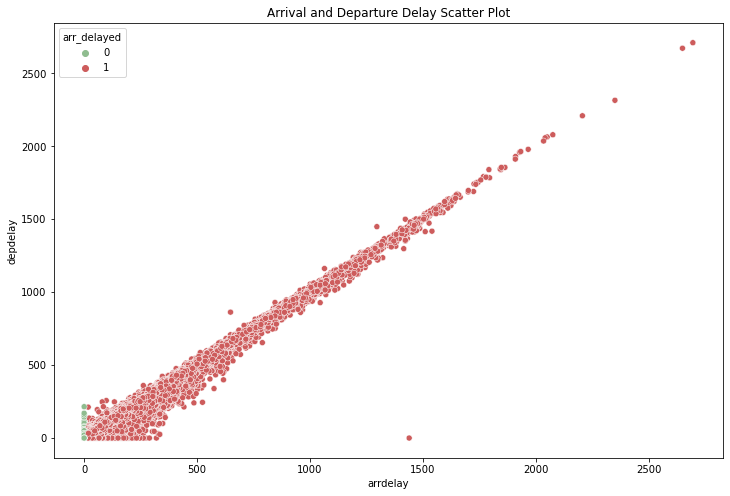

In [21]:
plt.figure(figsize=(12,8))
plt.title("Arrival and Departure Delay Scatter Plot")

sns.scatterplot(df['arrdelay'], df['depdelay'], 
                hue=df['arr_delayed'],
                palette=['darkseagreen','indianred']);

From the scatter plot above, we note that is an extreme outlier $\implies$ we will drop the outlying data.

In [22]:
# Identifying the outlier

df[(df['arrdelay']>1400) &
   (df['arrdelay']<1500) &
   (df['depdelay']<200)]

index  year  month  dayofmonth  dayofweek flightdate  \
1349212  1388655  2019      3          27          3 2019-03-27   

        reporting_airline tail_number origin originstate dest deststate  \
1349212                EV      N14542    JAX          FL  EWR        NJ   

         crsdeptime  deptime  depdelay  taxiout  taxiin  crsarrtime  arrtime  \
1349212         800     1216         0       35      12        1036     1035   

         arrdelay  crselapsedtime  actualelapsedtime  airtime  distance  \
1349212      1439             156               1604     1557       820   

         distancegroup  carrierdelay  weatherdelay  nasdelay  securitydelay  \
1349212              4             0             0      1424              0   

         lateaircraftdelay  arr_delayed  dep_delayed  delay  
1349212                 15            1            0      1

In [23]:
df.drop([df[(df['arrdelay']>1400) &
   (df['arrdelay']<1500) &
   (df['depdelay']<200)].index[0]], inplace=True)
df.shape

(7268231, 33)

We note that there are some flights with `arr_delay` longer than 1500 minutes. We will proceed to drop these data too.

In [24]:
df = df[df['arrdelay']<=1500]
df.shape

(7268123, 33)

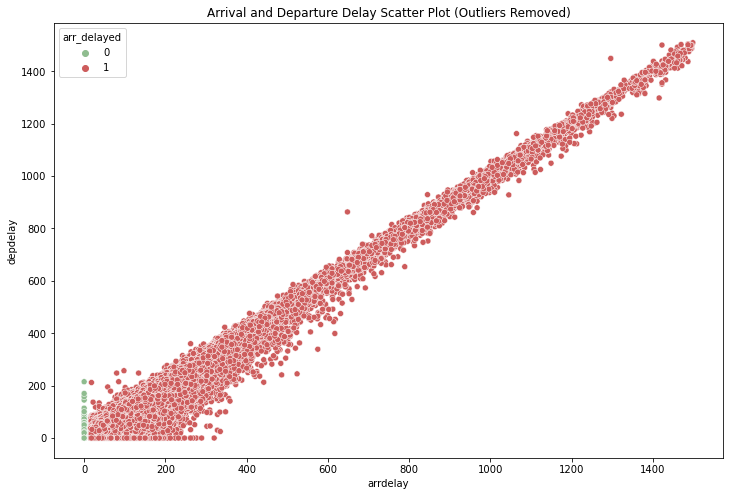

In [25]:
plt.figure(figsize=(12,8))
plt.title("Arrival and Departure Delay Scatter Plot (Outliers Removed)")

sns.scatterplot(df['arrdelay'], df['depdelay'], 
                hue=df['arr_delayed'],
                palette=['darkseagreen','indianred']);

# Exploratory Data Analysis


## Time Period - 2019 Flights & Delays

### Per Month
Creating a DataFrame `month_df` for the aggregated number of flights and delays per month.

In [27]:
month_df = pd.DataFrame(df.groupby(by="month").index.nunique())
month_df.columns = ['total']
month_df['delay'] = list(df.groupby(by="month")['delay'].sum())
month_df['perc_delay'] = round((month_df['delay']/month_df['total']*100),2)
month_df['no_delay'] =  month_df['total'] - month_df['delay']
print(month_df.shape)
month_df.head(3)

(12, 4)


total   delay  perc_delay  no_delay
month                                      
1      565959  120580       21.31    445379
2      516302  135256       26.20    381046
3      618494  124274       20.09    494220

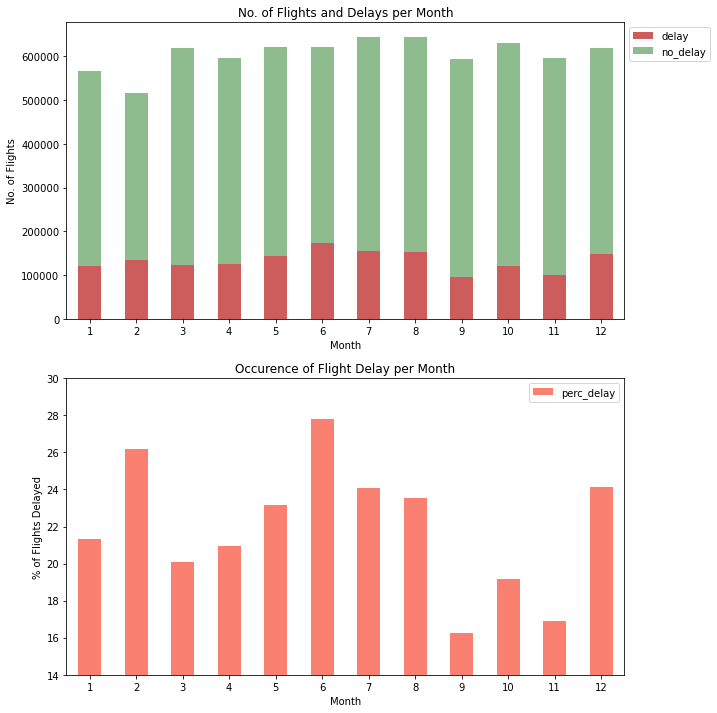

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,12))

# creating a stacked bar chart for monthly temperatures
month_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[0].set_xlabel('Month')
ax[0].set_xticklabels(labels = month_df.index,rotation=0)
ax[0].set_ylabel('No. of Flights')
ax[0].set_title('No. of Flights and Delays per Month')

# creating a bar chart for the percentage delay
month_df[['perc_delay']].plot(kind='bar', stacked=True, color=['salmon'],ax=ax[1])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[1].set_xlabel('Month')
ax[1].set_xticklabels(labels = month_df.index,rotation=0)
ax[1].set_ylabel('% of Flights Delayed')
ax[1].set_ylim(14,30)
ax[1].set_title('Occurence of Flight Delay per Month');


### Per Day of Month
Creating a DataFrame `day_month_df` for the aggregated number of flights and delays per day of month.

In [29]:
day_month_df = pd.DataFrame(df.groupby(by="dayofmonth").index.nunique())
day_month_df.columns = ['total']
day_month_df['delay'] = list(df.groupby(by="dayofmonth")['delay'].sum())
day_month_df['perc_delay'] = round((day_month_df['delay']/day_month_df['total']*100),2)
day_month_df['no_delay'] =  day_month_df['total'] - day_month_df['delay']
print(day_month_df.shape)
day_month_df.head(3)

(31, 4)


total  delay  perc_delay  no_delay
dayofmonth                                     
1           236454  58193       24.61    178261
2           232025  54690       23.57    177335
3           237230  48013       20.24    189217

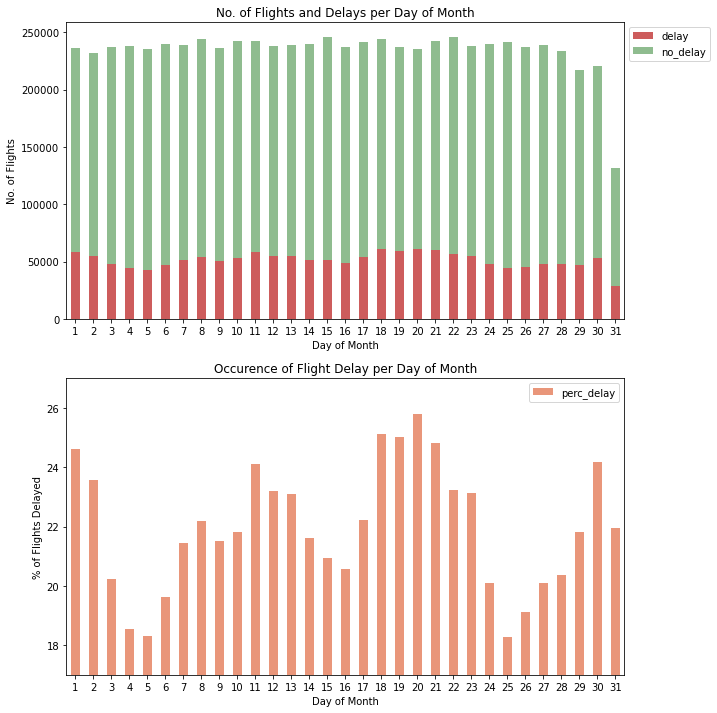

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,12))

day_month_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[0].set_xlabel('Day of Month')
ax[0].set_xticklabels(labels = day_month_df.index,rotation=0)
ax[0].set_ylabel('No. of Flights')
ax[0].set_title('No. of Flights and Delays per Day of Month')

# creating a bar chart for the percentage delay
day_month_df[['perc_delay']].plot(kind='bar', stacked=True, color=['darksalmon'],ax=ax[1])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[1].set_xlabel('Day of Month')
ax[1].set_xticklabels(labels = day_month_df.index,rotation=0)
ax[1].set_ylabel('% of Flights Delayed')
ax[1].set_ylim(17,27)
ax[1].set_title('Occurence of Flight Delay per Day of Month');


### Per Day of Week
Creating a DataFrame `day_week_df` for the aggregated number of flights and delays per day of week.

In [31]:
day_week_df = pd.DataFrame(df.groupby(by="dayofweek").index.nunique())
day_week_df.columns = ['total']
day_week_df['delay'] = list(df.groupby(by="dayofweek")['delay'].sum())
day_week_df['perc_delay'] = round((day_week_df['delay']/day_week_df['total']*100),2)
day_week_df['no_delay'] =  day_week_df['total'] - day_week_df['delay']
print(day_week_df.shape)
day_week_df.head(3)

(7, 4)


total   delay  perc_delay  no_delay
dayofweek                                       
1          1083736  246264       22.72    837472
2          1056048  217264       20.57    838784
3          1048490  223711       21.34    824779

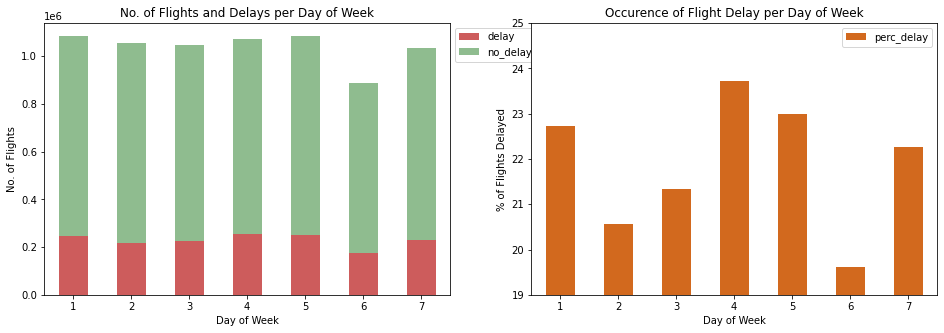

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

# creating a stacked bar chart for monthly temperatures
day_week_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[0].set_xlabel('Day of Week')
ax[0].set_xticklabels(labels = day_week_df.index,rotation=0)
ax[0].set_ylabel('No. of Flights')
ax[0].set_title('No. of Flights and Delays per Day of Week')

# creating a bar chart for the percentage delay
day_week_df[['perc_delay']].plot(kind='bar', stacked=True, color=['chocolate'],ax=ax[1])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[1].set_xlabel('Day of Week')
ax[1].set_xticklabels(labels = day_week_df.index,rotation=0)
ax[1].set_ylabel('% of Flights Delayed')
ax[1].set_ylim(19,25)
ax[1].set_title('Occurence of Flight Delay per Day of Week');


### Per Day

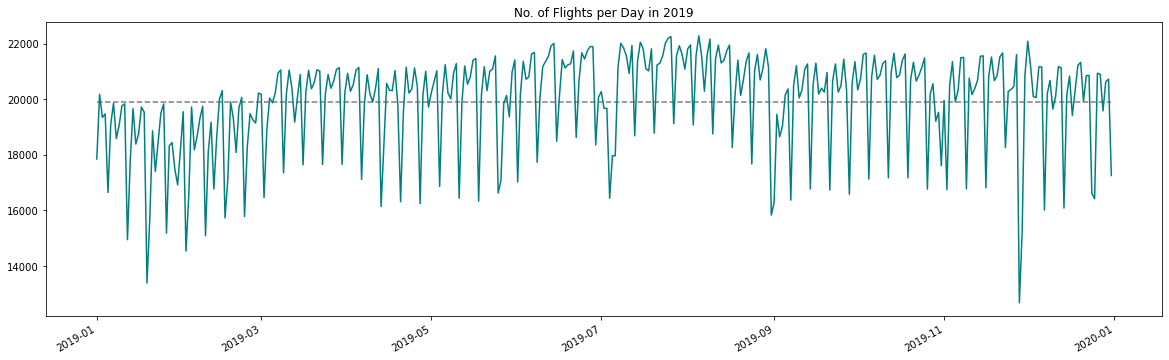

In [33]:
plt.figure(figsize=(20,6))
plt.title("No. of Flights per Day in 2019")
plt.hlines(y = df['flightdate'].value_counts().mean(),
           xmin = df['flightdate'].value_counts().index.min(),
           xmax = df['flightdate'].value_counts().index.max(),
           linestyles = '--',
           color ='grey')
df['flightdate'].value_counts().plot(color='teal');

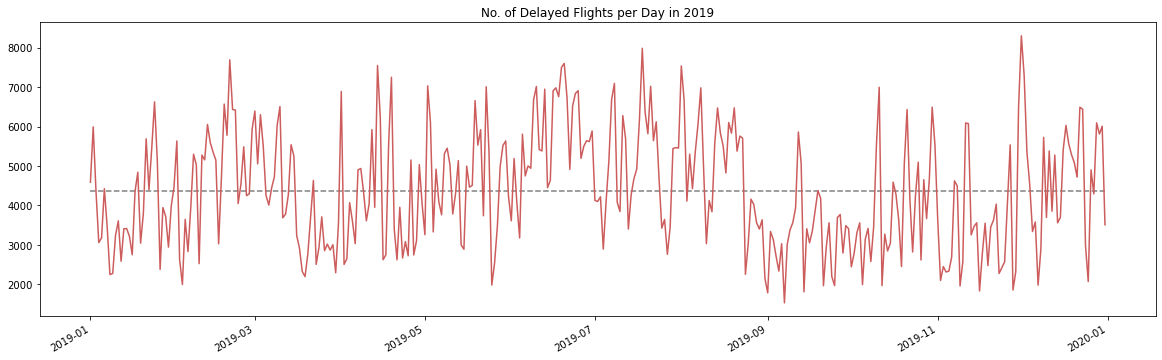

In [34]:
plt.figure(figsize=(20,6))
plt.title("No. of Delayed Flights per Day in 2019")
plt.hlines(y = df[df["delay"]==1]['flightdate'].value_counts().mean(),
           xmin = df[df["delay"]==1]['flightdate'].value_counts().index.min(),
           xmax = df[df["delay"]==1]['flightdate'].value_counts().index.max(),
           linestyles = '--',
           color ='grey')
df[df["delay"]==1]['flightdate'].value_counts().plot(color='indianred');

### Per Hour
We round down the arrival and departure time to the nearest hour to simplify visualisation.
- `crs_dep_hour`: `crs_dep_time` rounded down to the nearest hour
- `crs_arr_hour`: `crs_arr_time` rounded down to the nearest hour

In [35]:
df['crsdeptime'] = [str(time).zfill(4) for time in df['crsdeptime']]
df['crsarrtime'] = [str(time).zfill(4) for time in df['crsarrtime']]

In [36]:
df[['crsdeptime','crsarrtime']].head(3)

crsdeptime crsarrtime
0       1400       1510
1       0935       1118
2       0643       0855

In [37]:
# inserting the new column `crs_dep_hour` in the column after `crs_dep_time` 
# and `crs_arr_hour` in the column after `crs_arr_time`

df.insert(
    df.columns.get_loc("crsdeptime") + 1, "crsdephour",
    df['crsdeptime'].map(lambda x: str(x)[:-2]))
df.insert(
    df.columns.get_loc("crsarrtime") + 1, "crsarrhour",
    df['crsarrtime'].map(lambda x: str(x)[:-2]))
df.head(3)

index  year  month  dayofmonth  dayofweek flightdate reporting_airline  \
0      0  2019      1           4          5 2019-01-04                OO   
1      1  2019      1           4          5 2019-01-04                OO   
2      2  2019      1           4          5 2019-01-04                OO   

  tail_number origin originstate dest deststate crsdeptime crsdephour  \
0      N945SW    SBP          CA  SFO        CA       1400         14   
1      N932SW    IAH          TX  XNA        AR       0935         09   
2      N932SW    SGF          MO  IAH        TX       0643         06   

   deptime  depdelay  taxiout  taxiin crsarrtime crsarrhour  arrtime  \
0     1353         0        9       5       1510         15     1444   
1      930         0       27       6       1118         11     1119   
2      637         0       17      16       0855         08      838   

   arrdelay  crselapsedtime  actualelapsedtime  airtime  distance  \
0         0              70                 51       37       190   
1         0             103                109       76       438   
2         0             132                121       88       513   

   distancegroup  carrierdelay  weatherdelay  nasdelay  securitydelay  \
0              1             0             0         0              0   
1              2             0             0         0              0   
2              3             0             0         0              0   

   lateaircraftdelay  arr_delayed  dep_delayed  delay  
0                  0            0            0      0  
1                  0            0            0      0  
2                  0            0            0      0

In [38]:
df['crsdephour'] = pd.to_numeric(df['crsdephour'])
df['crsarrhour'] = pd.to_numeric(df['crsarrhour'])

df[['crsdephour','crsarrhour']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7268123 entries, 0 to 7268231
Data columns (total 2 columns):
 #   Column      Dtype
---  ------      -----
 0   crsdephour  int64
 1   crsarrhour  int64
dtypes: int64(2)
memory usage: 166.4 MB


In [39]:
dep_hour_df = pd.DataFrame(df["crsdephour"].value_counts().sort_index(ascending=True))
dep_hour_df.columns = ['total']
dep_hour_df['delay'] = list(df.groupby(by="crsdephour")['delay'].sum())
dep_hour_df['perc_delay'] = round(((dep_hour_df['delay']*100)/dep_hour_df['total']),2)
dep_hour_df['no_delay'] =  dep_hour_df['total'] - dep_hour_df['delay']
print(dep_hour_df.shape)
dep_hour_df.head(3)

(24, 4)


total  delay  perc_delay  no_delay
0  16034   3432       21.40     12602
1   6291   1432       22.76      4859
2   2278    652       28.62      1626

In [40]:
df[df['crsarrhour']==24].head(3)

index  year  month  dayofmonth  dayofweek flightdate  \
337781  350452  2019      1          11          5 2019-01-11   
338545  351217  2019      1          12          6 2019-01-12   
339214  351902  2019      1          13          7 2019-01-13   

       reporting_airline tail_number origin originstate dest deststate  \
337781                B6      N605JB    LGA          NY  MCO        FL   
338545                B6      N505JB    LGA          NY  MCO        FL   
339214                B6      N652JB    LGA          NY  MCO        FL   

       crsdeptime  crsdephour  deptime  depdelay  taxiout  taxiin crsarrtime  \
337781       2110          21     2133        23       20       8       2400   
338545       2110          21     2122         0        9       6       2400   
339214       2110          21     2133        23       43      12       2400   

        crsarrhour  arrtime  arrdelay  crselapsedtime  actualelapsedtime  \
337781          24        6         0             170                153   
338545          24     2351         0             170                149   
339214          24       47        47             170                194   

        airtime  distance  distancegroup  carrierdelay  weatherdelay  \
337781      125       950              4             0             0   
338545      134       950              4             0             0   
339214      139       950              4            22             0   

        nasdelay  securitydelay  lateaircraftdelay  arr_delayed  dep_delayed  \
337781         0              0                  0            0            1   
338545         0              0                  0            0            0   
339214        24              0                  1            1            1   

        delay  
337781      1  
338545      0  
339214      1

We note that there are 17 flights with `crs_arr_hour` = 24. This is probably a time format discrepancy; instead of dropping these columns, will change 24 to 0 for consistency.

In [41]:
df["crsarrhour"] = df["crsarrhour"].replace(24,0)

arr_hour_df = pd.DataFrame(df["crsarrhour"].value_counts().sort_index(ascending=True))
arr_hour_df.columns = ['total']
arr_hour_df['delay'] = list(df.groupby(by="crsarrhour")['delay'].sum())
arr_hour_df['perc_delay'] = round(((arr_hour_df['delay']*100)/arr_hour_df['total']),2)
arr_hour_df['no_delay'] =  arr_hour_df['total'] - arr_hour_df['delay']
print(arr_hour_df.shape)
arr_hour_df.tail(3)

(24, 4)


total   delay  perc_delay  no_delay
21  457222  135197       29.57    322025
22  336296  104049       30.94    232247
23  341712  101360       29.66    240352

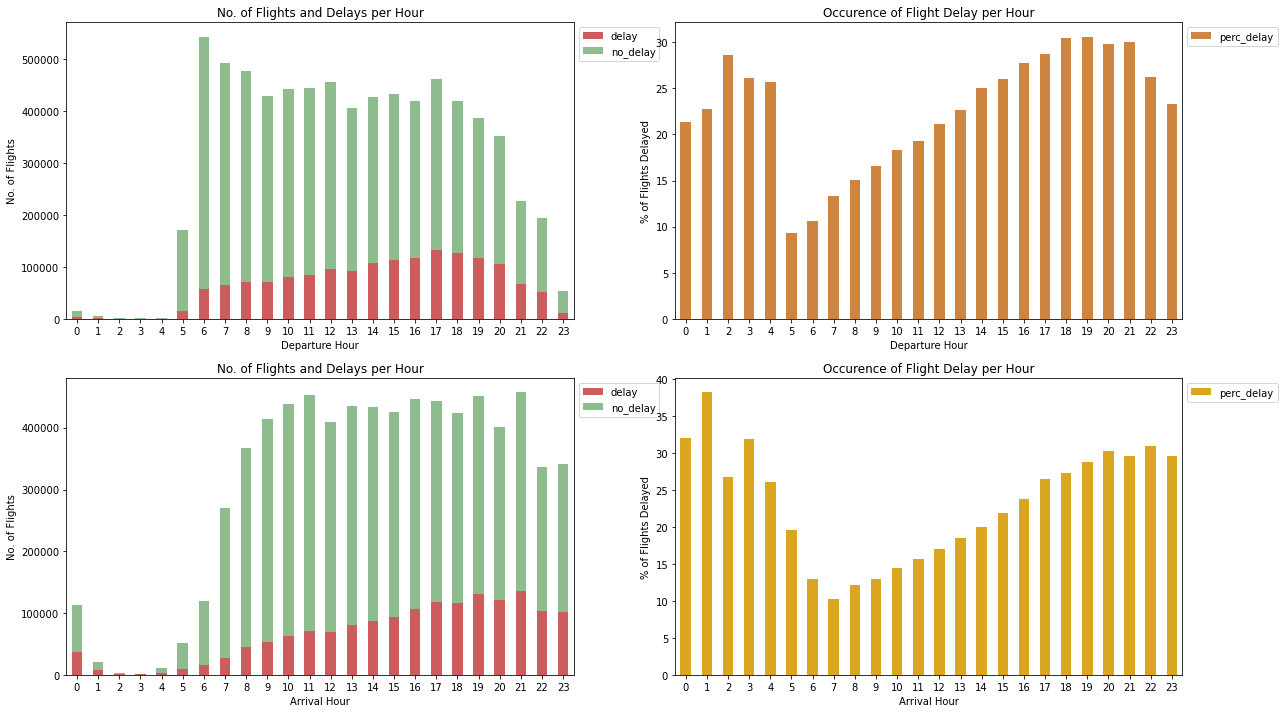

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

dep_hour_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[0,0])
ax[0,0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[0,0].set_xlabel('Departure Hour')
ax[0,0].set_xticklabels(labels = dep_hour_df.index,rotation=0)
ax[0,0].set_ylabel('No. of Flights')
ax[0,0].set_title('No. of Flights and Delays per Hour')

# --------------------------------------------------------------------------

dep_hour_df[['perc_delay']].plot(kind='bar', stacked=True, color=['peru'],ax=ax[0,1])
ax[0,1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[0,1].set_xlabel('Departure Hour')
ax[0,1].set_xticklabels(labels = dep_hour_df.index,rotation=0)
ax[0,1].set_ylabel('% of Flights Delayed')
ax[0,1].set_title('Occurence of Flight Delay per Hour')

# --------------------------------------------------------------------------

arr_hour_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[1,0])
ax[1,0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[1,0].set_xlabel('Arrival Hour')
ax[1,0].set_xticklabels(labels = arr_hour_df.index,rotation=0)
ax[1,0].set_ylabel('No. of Flights')
ax[1,0].set_title('No. of Flights and Delays per Hour')

# --------------------------------------------------------------------------

arr_hour_df[['perc_delay']].plot(kind='bar', stacked=True, color=['goldenrod'],ax=ax[1,1])
ax[1,1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[1,1].set_xlabel('Arrival Hour')
ax[1,1].set_xticklabels(labels = arr_hour_df.index,rotation=0)
ax[1,1].set_ylabel('% of Flights Delayed')
ax[1,1].set_title('Occurence of Flight Delay per Hour');

In [43]:
arr_hour_df[['perc_delay']].plot(kind='bar', stacked=True, color=['goldenrod'],ax=ax[1,1])
ax[1,1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[1,1].set_xlabel('Arrival Hour')
ax[1,1].set_xticklabels(labels = arr_hour_df.index,rotation=0)
ax[1,1].set_ylabel('% of Flights Delayed')
ax[1,1].set_title('Occurence of Flight Delay per Hour');

### Summary:

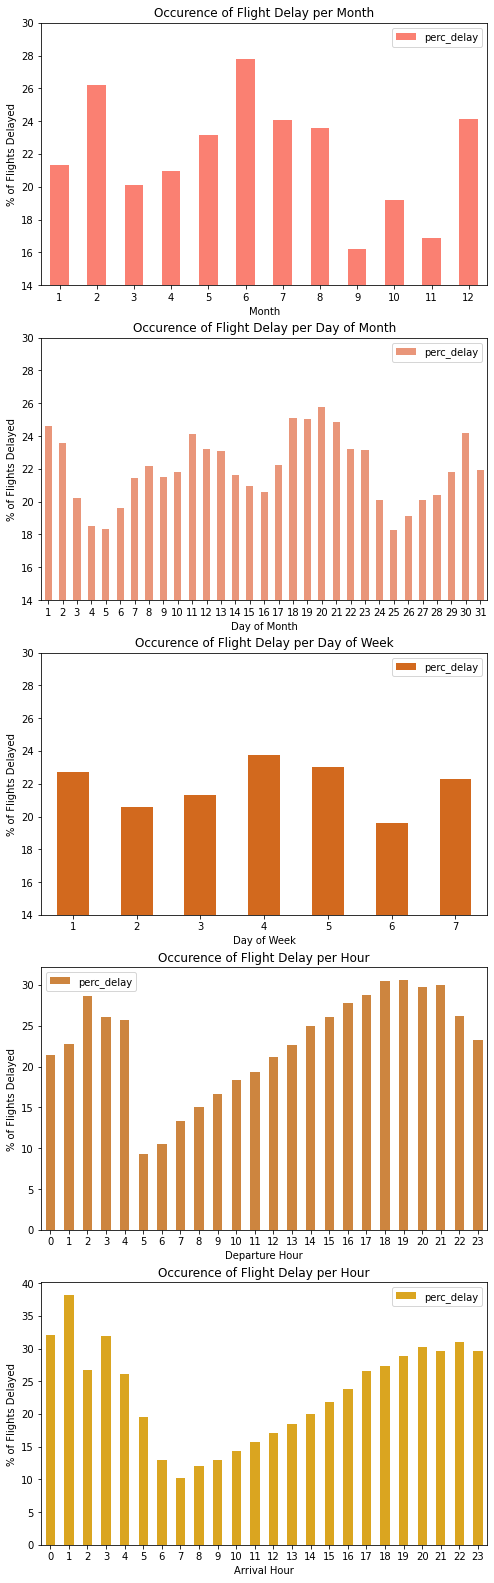

In [44]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(8,28))

month_df[['perc_delay']].plot(kind='bar', stacked=True, color=['salmon'],ax=ax[0])
ax[0].set_xlabel('Month')
ax[0].set_xticklabels(labels = month_df.index,rotation=0)
ax[0].set_ylabel('% of Flights Delayed')
ax[0].set_ylim(14,30)
ax[0].set_title('Occurence of Flight Delay per Month')


day_month_df[['perc_delay']].plot(kind='bar', stacked=True, color=['darksalmon'],ax=ax[1])
ax[1].set_xlabel('Day of Month')
ax[1].set_xticklabels(labels = day_month_df.index,rotation=0)
ax[1].set_ylabel('% of Flights Delayed')
ax[1].set_ylim(14,30)
ax[1].set_title('Occurence of Flight Delay per Day of Month')


day_week_df[['perc_delay']].plot(kind='bar', stacked=True, color=['chocolate'],ax=ax[2])
ax[2].set_xlabel('Day of Week')
ax[2].set_xticklabels(labels = day_week_df.index,rotation=0)
ax[2].set_ylabel('% of Flights Delayed')
ax[2].set_ylim(14,30)
ax[2].set_title('Occurence of Flight Delay per Day of Week')

dep_hour_df[['perc_delay']].plot(kind='bar', stacked=True, color=['peru'],ax=ax[3])
ax[3].set_xlabel('Departure Hour')
ax[3].set_xticklabels(labels = dep_hour_df.index,rotation=0)
ax[3].set_ylabel('% of Flights Delayed')
ax[3].set_title('Occurence of Flight Delay per Hour')


arr_hour_df[['perc_delay']].plot(kind='bar', stacked=True, color=['goldenrod'],ax=ax[4])
ax[4].set_xlabel('Arrival Hour')
ax[4].set_xticklabels(labels = arr_hour_df.index,rotation=0)
ax[4].set_ylabel('% of Flights Delayed')
ax[4].set_title('Occurence of Flight Delay per Hour');

Looking at the percentage of flight delay (i) per Day of Week, (ii) per Day of Month, and (iii) per Month, we can see that there is not much variation in the % of flights delayed (i) per Day of Week, as compared to (ii) and (iii).

We note that flight delay % is generally 
- **higher** in the
    - third week (18th ~ 23th of each month)
    - months - February & June
- **lower** in the
    - first week (3rd ~ 6th of each month) and last week (24th ~ 28th of each month)
    - months - September ~ November

## Arrival Delay vs Departure Delay

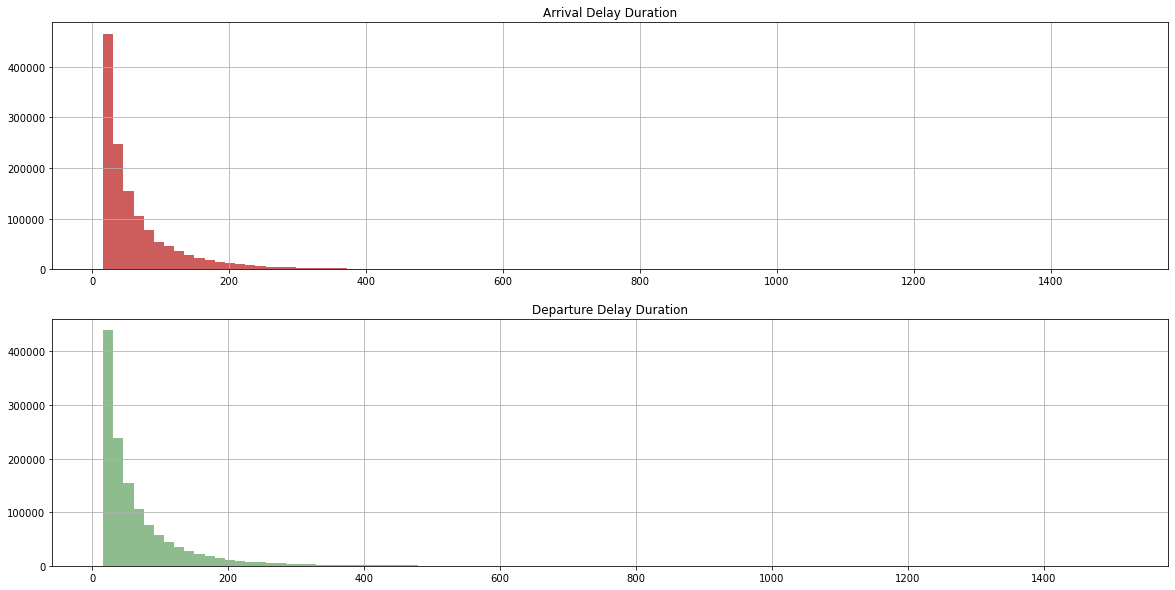

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10))


df[df['arr_delayed']==1]['arrdelay'].hist(bins=100, color='indianred',ax=ax[0])
ax[0].set_title("Arrival Delay Duration")

df[df['dep_delayed']==1]['depdelay'].hist(bins=100, color='darkseagreen',ax=ax[1])
ax[1].set_title("Departure Delay Duration");

In [46]:
df.head()

index  year  month  dayofmonth  dayofweek flightdate reporting_airline  \
0      0  2019      1           4          5 2019-01-04                OO   
1      1  2019      1           4          5 2019-01-04                OO   
2      2  2019      1           4          5 2019-01-04                OO   
3      3  2019      1           4          5 2019-01-04                OO   
4      4  2019      1           4          5 2019-01-04                OO   

  tail_number origin originstate dest deststate crsdeptime  crsdephour  \
0      N945SW    SBP          CA  SFO        CA       1400          14   
1      N932SW    IAH          TX  XNA        AR       0935           9   
2      N932SW    SGF          MO  IAH        TX       0643           6   
3      N916SW    ISN          ND  DEN        CO       1335          13   
4      N107SY    MKE          WI  DEN        CO       0836           8   

   deptime  depdelay  taxiout  taxiin crsarrtime  crsarrhour  arrtime  \
0     1353         0        9       5       1510          15     1444   
1      930         0       27       6       1118          11     1119   
2      637         0       17      16       0855           8      838   
3     1314         0       23       7       1433          14     1404   
4      826         0       26      10       1040          10     1009   

   arrdelay  crselapsedtime  actualelapsedtime  airtime  distance  \
0         0              70                 51       37       190   
1         0             103                109       76       438   
2         0             132                121       88       513   
3         0             118                110       80       576   
4         0             184                163      127       896   

   distancegroup  carrierdelay  weatherdelay  nasdelay  securitydelay  \
0              1             0             0         0              0   
1              2             0             0         0              0   
2              3             0             0         0              0   
3              3             0             0         0              0   
4              4             0             0         0              0   

   lateaircraftdelay  arr_delayed  dep_delayed  delay  
0                  0            0            0      0  
1                  0            0            0      0  
2                  0            0            0      0  
3                  0            0            0      0  
4                  0            0            0      0

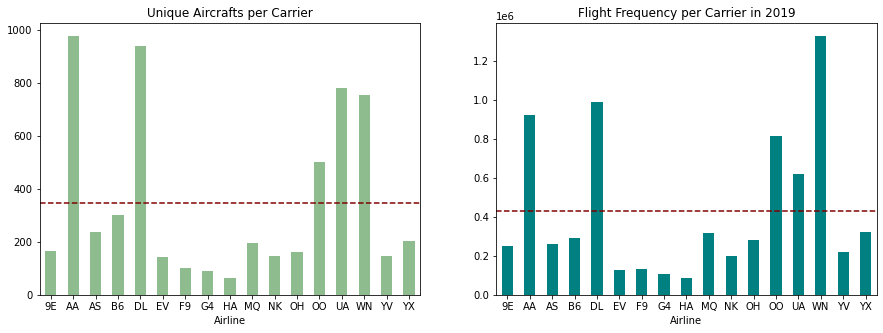

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df.groupby("reporting_airline")['tail_number'].nunique().plot(
    kind='bar', color="darkseagreen", ax=ax[0]

).axhline(y=df.groupby(
        "reporting_airline")['tail_number'].nunique().mean(),
                                                        color='maroon',
                                                        linestyle='--')

ax[0].set_xticklabels(
    df['reporting_airline'].value_counts().sort_index(ascending=True).index,
    rotation=0)
ax[0].set_xlabel('Airline')
ax[0].set_title("Unique Aircrafts per Carrier")

# --------------------------------------------------------------------------

df['reporting_airline'].value_counts().sort_index(ascending=True).plot(
    kind='bar', color="teal",ax=ax[1]

).axhline(y=df['reporting_airline'].value_counts().mean(),
                      color='maroon',
                      linestyle='--')

ax[1].set_xticklabels(
    df['reporting_airline'].value_counts().sort_index(ascending=True).index,
    rotation=0)
ax[1].set_xlabel('Airline')
ax[1].set_title("Flight Frequency per Carrier in 2019");

In [48]:
df.groupby("reporting_airline")['tail_number'].value_counts().head(10)

reporting_airline  tail_number
9E                 N8886A         1834
                   N8839E         1830
                   N8896A         1825
                   N819AY         1811
                   N8943A         1805
                   N8986B         1803
                   N8970D         1800
                   N8976E         1796
                   N300PQ         1786
                   N8974C         1776
Name: tail_number, dtype: int64

In [49]:
aircraft_df = pd.DataFrame(df.groupby("reporting_airline")['tail_number'].nunique())
aircraft_df.columns = ['aircraft_count']
aircraft_df['flight_count'] = df['reporting_airline'].value_counts().sort_index(ascending=True)
aircraft_df

aircraft_count  flight_count
reporting_airline                              
9E                            164        252347
AA                            978        924196
AS                            236        261015
B6                            303        292720
DL                            940        988025
EV                            143        128172
F9                            101        133061
G4                             91        104439
HA                             63         83688
MQ                            196        314642
NK                            146        200891
OH                            161        281646
OO                            501        815820
UA                            783        618705
WN                            753       1327562
YV                            145        220579
YX                            204        320615

### Airline Delays

In [50]:
airline_df = pd.DataFrame(df.groupby(by="reporting_airline").index.nunique())
airline_df.columns = ['total']
airline_df['delay'] = list(df.groupby(by="reporting_airline")['delay'].sum())
airline_df['perc_delay'] = round((airline_df['delay']/airline_df['total']*100),2)
airline_df['no_delay'] =  airline_df['total'] - airline_df['delay']
print(airline_df.shape)
airline_df.head(3)

(17, 4)


total   delay  perc_delay  no_delay
reporting_airline                                      
9E                 252347   49571       19.64    202776
AA                 924196  222218       24.04    701978
AS                 261015   54887       21.03    206128

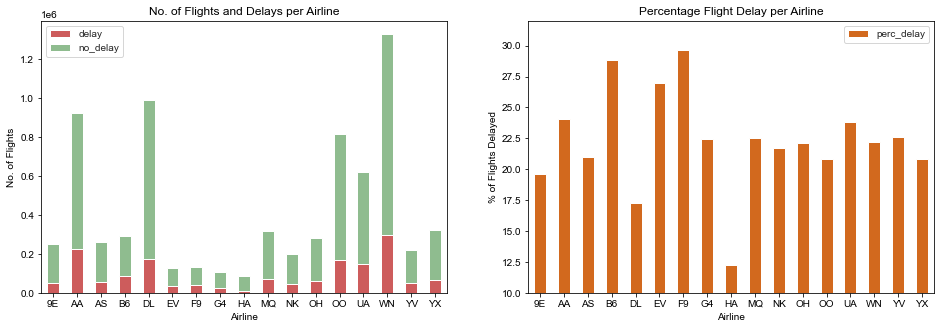

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.set_style("white")

# creating a stacked bar chart for monthly temperatures
airline_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[0].set_xlabel('Airline')
ax[0].set_xticklabels(labels = airline_df.index,rotation=0)
ax[0].set_ylabel('No. of Flights')
ax[0].set_title('No. of Flights and Delays per Airline')

# creating a bar chart for the percentage delay
airline_df[['perc_delay']].plot(kind='bar', stacked=True, color=['chocolate'],ax=ax[1])
ax[0].legend( loc='upper left')

# labels for x & y axis
ax[1].set_xlabel('Airline')
ax[1].set_xticklabels(labels = airline_df.index,rotation=0)
ax[1].set_ylabel('% of Flights Delayed')
ax[1].set_ylim(10,32)
ax[1].set_title('Percentage Flight Delay per Airline');


We can see that the airlines with the highest frequency of delays are:
1. JetBlue (B6) - 29%
2. ExpressJet (EV) - 27%
3. Frontier (F9) - 30%

Airlines with the lowest frequency of delays are:
1. Hawaiian (HA) - 12%
2. Delta (DL) - 17%
3. Endeavor (9E) - 20%

## Origin & Destination 
### State

In [52]:
# Number of airport in each state
state_df = pd.DataFrame(df.groupby('originstate')['origin'].nunique())
state_df.columns = ['no_of_airport'] 

print(f"Total No. of States: {state_df.shape[0]}")
print(f"Total No. of Airports: {state_df.no_of_airport.sum()}")

state_df.head()

Total No. of States: 52
Total No. of Airports: 360


no_of_airport
originstate               
AK                      19
AL                       6
AR                       4
AZ                       6
CA                      22

In [53]:
state_df['no_of_dest_airport'] = df.groupby('originstate')['dest'].nunique()
state_df['no_of_dest_state'] = df.groupby('originstate')['deststate'].nunique()
state_df['no_of_departure'] = df['originstate'].value_counts().sort_index()
state_df['no_of_arrival'] = df['deststate'].value_counts().sort_index()

print(f"Total No. of Destination Airports: {state_df.no_of_dest_airport.sum()}")
print(f"Total No. of Destination States: {state_df.no_of_dest_state.sum()}")
print(f"Total No. of Flights Departed from State: {state_df.no_of_departure.sum()}")
print(f"Total No. of Flights Landed in State: {state_df.no_of_arrival.sum()}")

state_df.head()

Total No. of Destination Airports: 3381
Total No. of Destination States: 1343
Total No. of Flights Departed from State: 7268123
Total No. of Flights Landed in State: 7268123


no_of_airport  no_of_dest_airport  no_of_dest_state  \
originstate                                                        
AK                      19                  36                13   
AL                       6                  24                14   
AR                       4                  24                17   
AZ                       6                 131                40   
CA                      22                 123                43   

             no_of_departure  no_of_arrival  
originstate                                  
AK                     39101          39122  
AL                     38966          39086  
AR                     31103          31149  
AZ                    201802         201733  
CA                    798676         799128

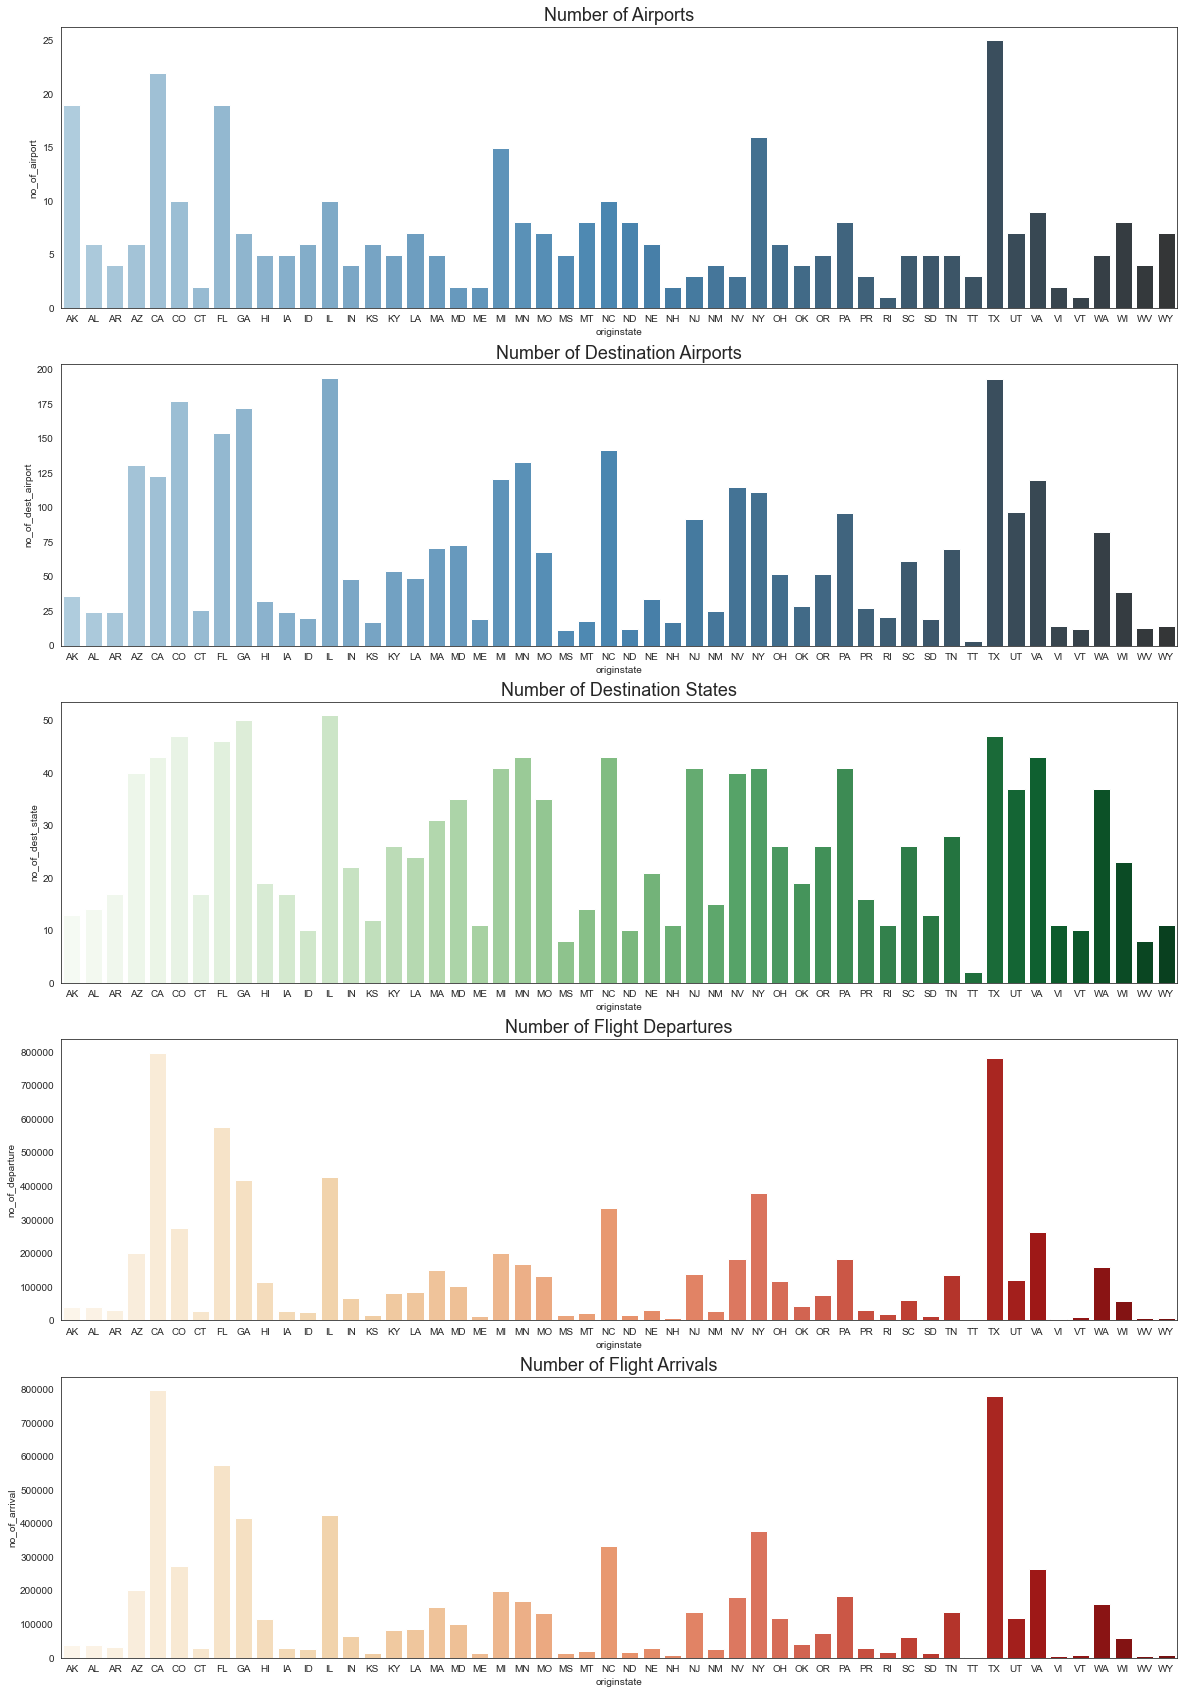

In [54]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 30))
titles = ["Airports", "Destination Airports", "Destination States", "Flight Departures","Flight Arrivals"]
palette = ["Blues_d", "Blues_d", "Greens", "OrRd", "OrRd"]

for i in range(5):
    sns.barplot(state_df.index,
                state_df[str(state_df.columns[i])],
                palette=palette[i],
                ax=ax[i])
    ax[i].set_title("Number of " + titles[i], fontsize=18)

From the bar plots above, we can see that states with more airports generally have a more diverse network of destination airports and states. These states also have heavier air traffic as there are higher number of flight departures and arrivals.

We note that there are some exceptions - 
- Alaska (AK) has many airports but little destination airports and states, air traffic is also very low.
    - It seems that due to the small population combined with the large area of the state, much of which is wilderness, most of Alaska is both uninhabited and almost entirely undeveloped. This leads to many towns with no roads leading to them, which are only accessible by airplane (although many coastal villages are also accessible by ship, they nonetheless do not contain any roads accessible by the rest of North America). Because of this, virtually every town in Alaska has an airport. [Source](https://en.wikipedia.org/wiki/List_of_airports_in_Alaska)
        
- On the other hand, states such as Arizona (AZ), Colorado (CO) Illinois (IL), North Carolina (NC) have low number of airports but many destination airports and states. Though air traffic is not too heavy in Arizona (AZ) and Colorado (CO); air traffic is heavy in Illinois (IL) and North Carolina (NC).

### Origin & Destination Airport

In [55]:
# Number of airports 
state_df = pd.DataFrame(df.groupby('originstate')['origin'].nunique())
state_df.columns = ['no_of_airport'] 

state_df['no_of_dest_airport'] = df.groupby('originstate')['dest'].nunique()
state_df['no_of_dest_state'] = df.groupby('originstate')['deststate'].nunique()
state_df['no_of_departure'] = df['originstate'].value_counts().sort_index()
state_df['no_of_arrival'] = df['deststate'].value_counts().sort_index()

print(f"Total No. of Destination Airports: {state_df.no_of_dest_airport.sum()}")
print(f"Total No. of Destination States: {state_df.no_of_dest_state.sum()}")
print(f"Total No. of Flights Departed from State: {state_df.no_of_departure.sum()}")
print(f"Total No. of Flights Landed in State: {state_df.no_of_arrival.sum()}")

state_df.head()

Total No. of Destination Airports: 3381
Total No. of Destination States: 1343
Total No. of Flights Departed from State: 7268123
Total No. of Flights Landed in State: 7268123


no_of_airport  no_of_dest_airport  no_of_dest_state  \
originstate                                                        
AK                      19                  36                13   
AL                       6                  24                14   
AR                       4                  24                17   
AZ                       6                 131                40   
CA                      22                 123                43   

             no_of_departure  no_of_arrival  
originstate                                  
AK                     39101          39122  
AL                     38966          39086  
AR                     31103          31149  
AZ                    201802         201733  
CA                    798676         799128

In [56]:
state_df['no_of_departure'] = df['originstate'].value_counts().sort_index()
state_df['no_of_arrival'] = df['deststate'].value_counts().sort_index()

In [57]:
# Number of airports (flight origin)
ori_airport_df = pd.DataFrame(df['origin'].value_counts().sort_index(ascending=True))
ori_airport_df.columns = ['total'] 
ori_airport_df['delay'] = list(df.groupby(by="origin")['delay'].sum())
ori_airport_df['perc_delay'] = round(((ori_airport_df['delay']*100)/ori_airport_df['total']),2)
ori_airport_df['no_delay'] =  ori_airport_df['total'] - ori_airport_df['delay']
ori_airport_df.sort_values(by="total",ascending=False, inplace=True)
ori_airport_df.head()

total  delay  perc_delay  no_delay
ATL  391701  74122       18.92    317579
ORD  328128  92231       28.11    235897
DFW  295644  76740       25.96    218904
DEN  246475  65015       26.38    181460
CLT  231325  52920       22.88    178405

In [58]:
# Number of airports (flight destination)
dest_airport_df = pd.DataFrame(df['dest'].value_counts().sort_index(ascending=True))
dest_airport_df.columns = ['total'] 
dest_airport_df['delay'] = list(df.groupby(by="dest")['delay'].sum())
dest_airport_df['perc_delay'] = round(((dest_airport_df['delay']*100)/dest_airport_df['total']),2)
dest_airport_df['no_delay'] =  dest_airport_df['total'] - dest_airport_df['delay']
dest_airport_df.sort_values(by="total",ascending=False, inplace=True)
dest_airport_df.head()

total  delay  perc_delay  no_delay
ATL  391731  65743       16.78    325988
ORD  327642  82063       25.05    245579
DFW  294771  67387       22.86    227384
DEN  246129  55423       22.52    190706
CLT  230770  44707       19.37    186063

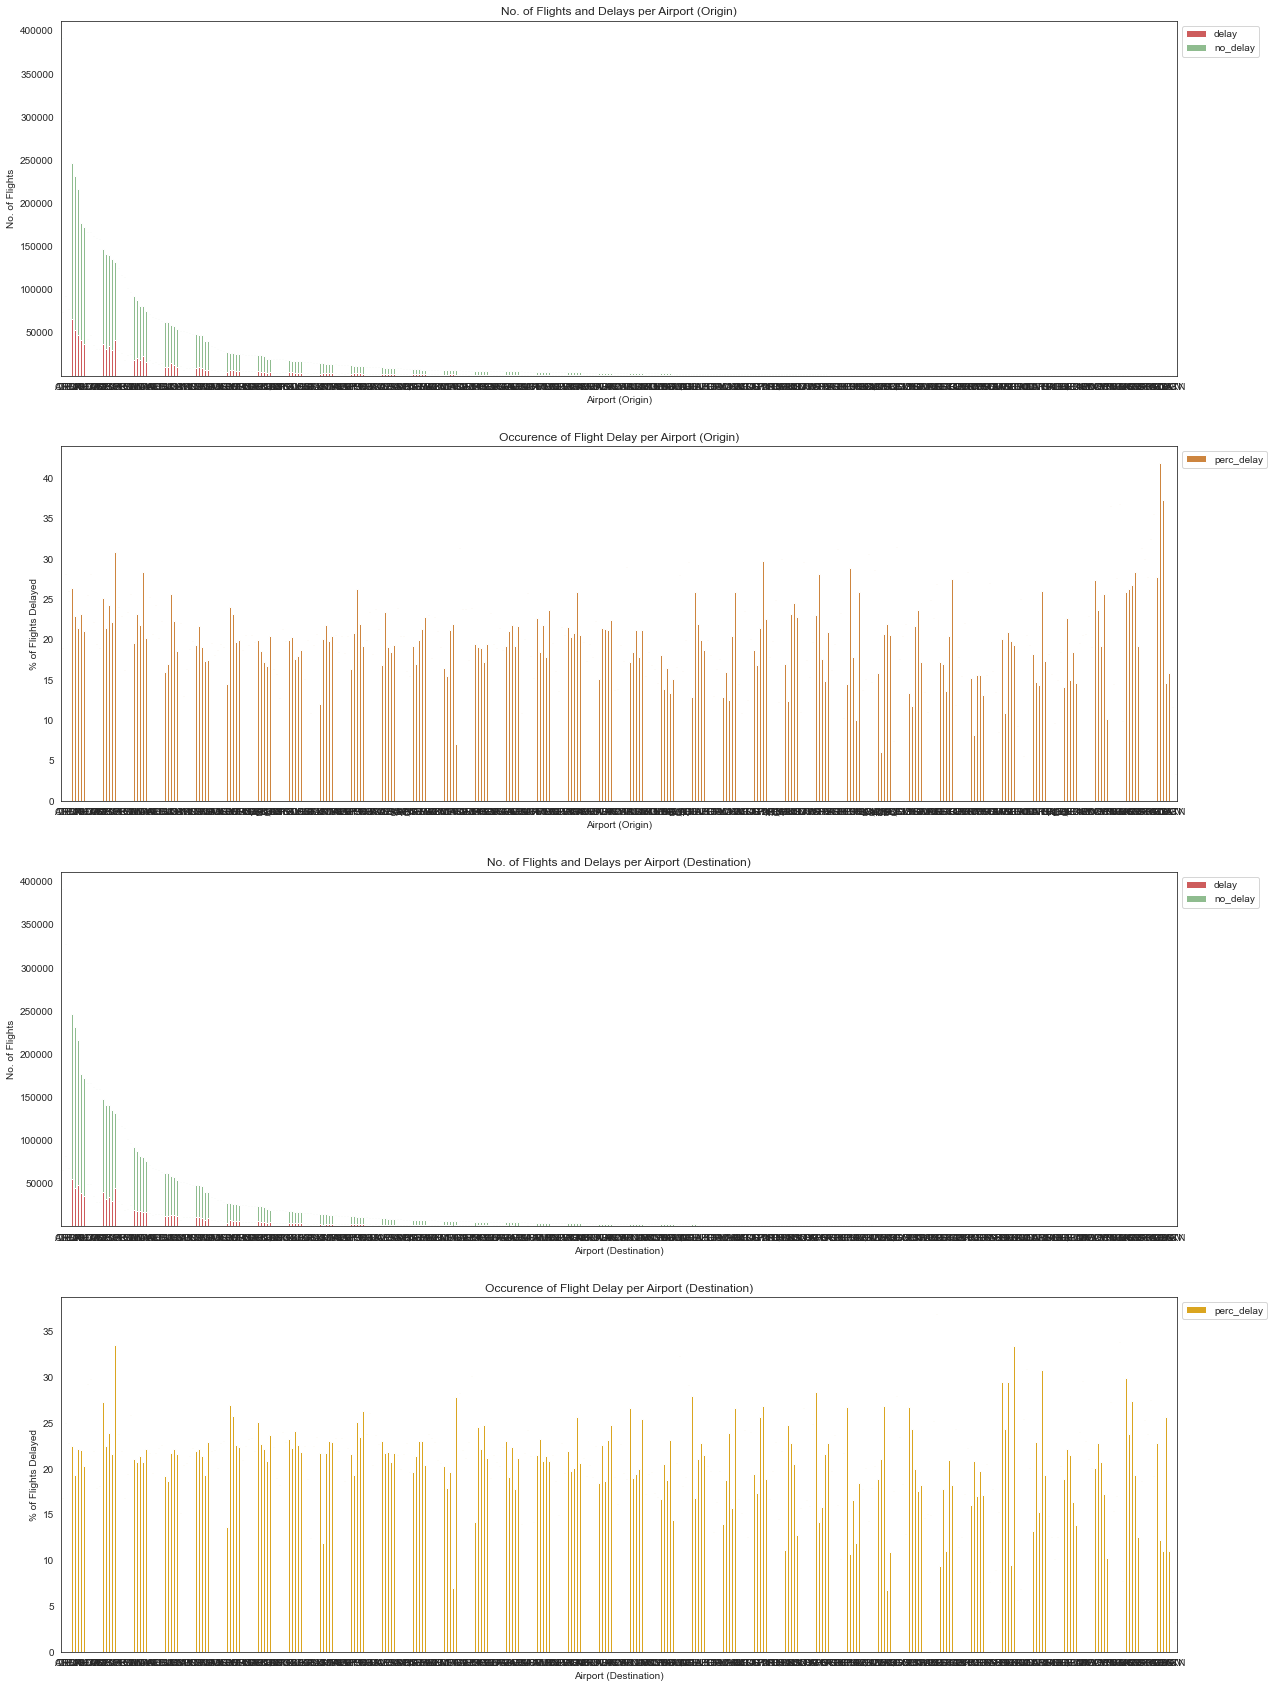

In [59]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,30))

ori_airport_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[0].set_xlabel('Airport (Origin)')
ax[0].set_xticklabels(labels = ori_airport_df.index,rotation=0)
ax[0].set_ylabel('No. of Flights')
ax[0].set_title('No. of Flights and Delays per Airport (Origin)')

# --------------------------------------------------------------------------

ori_airport_df[['perc_delay']].plot(kind='bar', stacked=True, color=['peru'],ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[1].set_xlabel('Airport (Origin)')
ax[1].set_xticklabels(labels = ori_airport_df.index,rotation=0)
ax[1].set_ylabel('% of Flights Delayed')
ax[1].set_title('Occurence of Flight Delay per Airport (Origin)')

# --------------------------------------------------------------------------

dest_airport_df[['delay','no_delay']].plot(kind='bar', stacked=True, color=['indianred', 'darkseagreen'],ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[2].set_xlabel('Airport (Destination)')
ax[2].set_xticklabels(labels = dest_airport_df.index,rotation=0)
ax[2].set_ylabel('No. of Flights')
ax[2].set_title('No. of Flights and Delays per Airport (Destination)')

# --------------------------------------------------------------------------

dest_airport_df[['perc_delay']].plot(kind='bar', stacked=True, color=['goldenrod'],ax=ax[3])
ax[3].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# labels for x & y axis
ax[3].set_xlabel('Airport (Destination)')
ax[3].set_xticklabels(labels = dest_airport_df.index,rotation=0)
ax[3].set_ylabel('% of Flights Delayed')
ax[3].set_title('Occurence of Flight Delay per Airport (Destination)');

We can see that those Airports with lower traffic flow also have a larger variance for percentage delay, which is not surprising because lesser data (flights) decreases the data to noise ratio, which increases the variance as seen in our barplot.

## Flight Distance & Duration

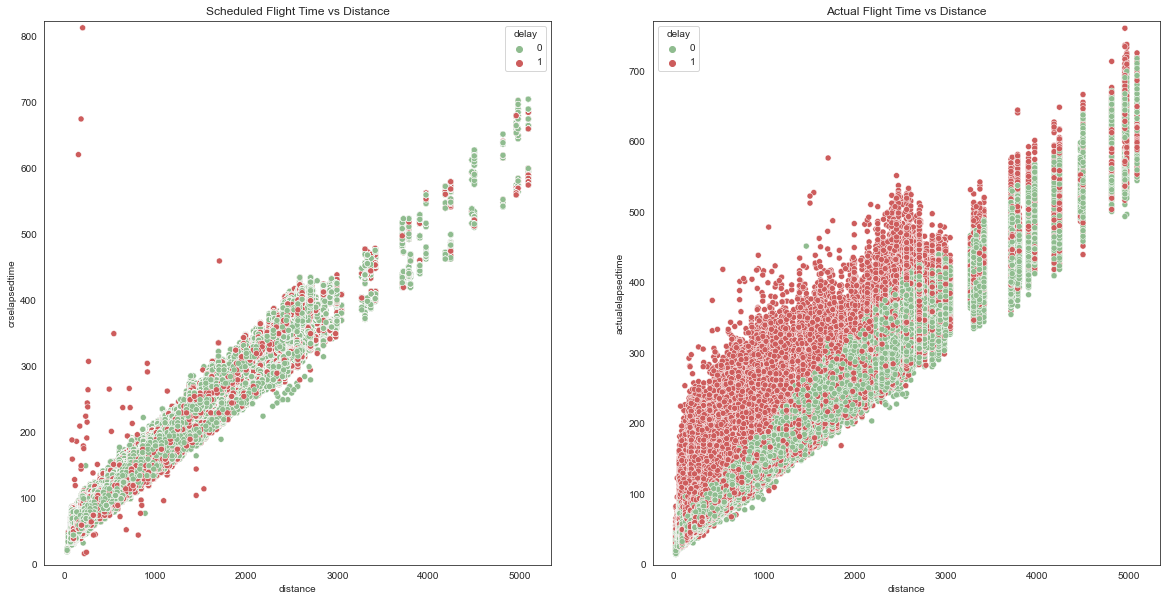

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

color_dict = {0: "darkseagreen", 1: "indianred"}

sns.scatterplot(data=df, x="distance", y="crselapsedtime", hue="delay", palette=color_dict, ax=ax[0])
ax[0].set_ylim(0,df['crselapsedtime'].max()+10)
ax[0].set_title('Scheduled Flight Time vs Distance');

# --------------------------------------------------------------------------

sns.scatterplot(data=df, x="distance", y="actualelapsedtime", hue="delay", palette=color_dict, ax=ax[1])
ax[1].set_ylim(0,df['actualelapsedtime'].max()+10)
ax[1].set_title('Actual Flight Time vs Distance');


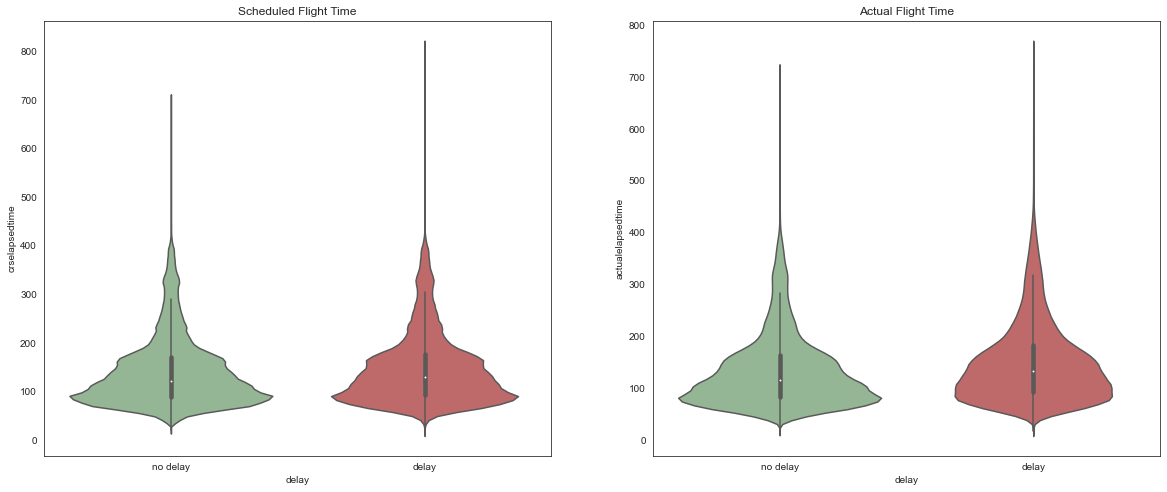

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

color_dict = {0: "darkseagreen", 1: "indianred"}

sns.violinplot(data=df, y="crselapsedtime", x="delay", ax=ax[0], palette=color_dict)
ax[0].set_xticklabels(["no delay","delay"])
ax[0].set_title('Scheduled Flight Time');

# --------------------------------------------------------------------------

sns.violinplot(data=df, y="actualelapsedtime", x="delay", ax=ax[1], palette=color_dict)
ax[1].set_xticklabels(["no delay","delay"])
ax[1].set_title('Actual Flight Time');


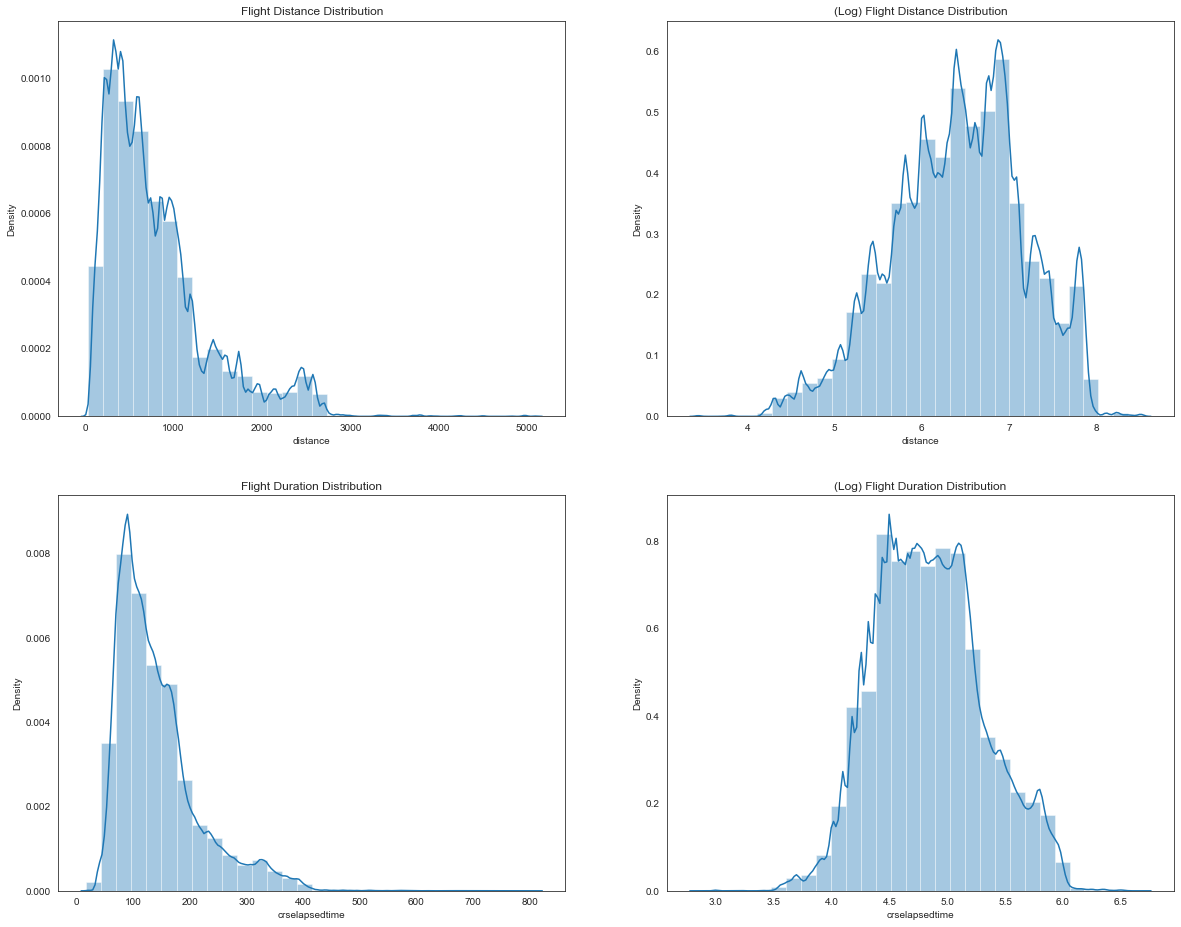

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))

sns.distplot(df['distance'], bins=30, kde=True, ax=ax[0,0])
ax[0,0].set_title("Flight Distance Distribution")

sns.distplot(np.log(df['distance']), bins=30, kde=True, ax=ax[0,1])
ax[0,1].set_title("(Log) Flight Distance Distribution")

sns.distplot(df['crselapsedtime'], bins=30, kde=True, ax=ax[1,0])
ax[1,0].set_title("Flight Duration Distribution")

sns.distplot(np.log(df['crselapsedtime']), bins=30, kde=True, ax=ax[1,1])
ax[1,1].set_title("(Log) Flight Duration Distribution");


Observation:
- Flights distance distribution is positively skewed 
- Logarithm of Flights distance distribution is more normally distributed. 
- We will consider using both, flight duration column and its logarithm for regression model.

In [63]:
df['log_distance'] = np.log(df['crselapsedtime'])
df['log_crselapsedtime'] = np.log(df['crselapsedtime'])

print(df['distance'].corr(np.log(df['crselapsedtime'])))
print(df['crselapsedtime'].corr(np.log(df['crselapsedtime'])))

0.9358109572299056
0.9570042437321735


## Reason of Delay

In [66]:
delay_col = ['carrierdelay', 'weatherdelay', 'nasdelay','securitydelay', 'lateaircraftdelay']
delay_count = []

for col in delay_col:
    print(f'No. of {col.title()} : {df[df[col] != 0].shape[0]}')
    delay_count.append(df[df[col] != 0].shape[0])
    print(f'Mean {col.title()} : {round(df[df[col] != 0][col].mean())}')
    print(f'Maximum {col.title()} : {df[df[col] != 0][col].max()}')
    print()

No. of Carrierdelay : 674620
Mean Carrierdelay : 43
Maximum Carrierdelay : 1498

No. of Weatherdelay : 82227
Mean Weatherdelay : 64
Maximum Weatherdelay : 1486

No. of Nasdelay : 745194
Mean Nasdelay : 31
Maximum Nasdelay : 1493

No. of Securitydelay : 4531
Mean Securitydelay : 29
Maximum Securitydelay : 1078

No. of Lateaircraftdelay : 720331
Mean Lateaircraftdelay : 53
Maximum Lateaircraftdelay : 1466



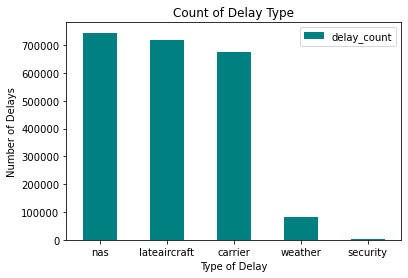

In [67]:
delay_df = pd.DataFrame(data=delay_count, index=[col[:-5] for col in delay_col])
delay_df.columns = ['delay_count']
delay_df.sort_values(ascending=False, by='delay_count', inplace=True)

delay_df.plot(kind='bar', color='teal')
plt.title('Count of Delay Type')
plt.xlabel('Type of Delay')
plt.ylabel('Number of Delays')
plt.xticks(rotation=0);

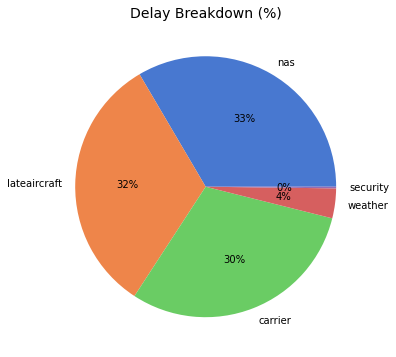

In [68]:
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111)

colors = sns.color_palette('muted')

patches, texts, autotexts = ax.pie(delay_df['delay_count'], 
       colors=colors, 
       labels=list(delay_df.index), 
       labeldistance=1.1, 
       autopct='%.0f%%')
ax.set_title("Delay Breakdown (%)", fontsize=14);

Most of the delays were due to:

1. NAS 
2. Late-arriving aircraft
3. Air Carrier

**[Causes of Flight Delays and Cancellations:](https://www.bts.dot.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations)**
- **Air Carrier:** The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
- **Extreme Weather:** Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane.
- **National Aviation System (NAS):** Delays and cancellations attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
- **Late-arriving aircraft:** A previous flight with same aircraft arrived late, causing the present flight to depart late.
- **Security:** Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.


# Feature Engineering

## Flight Sector per Day

Especially for low-cost carriers, most of their flights are short-haul and quick aircraft turnaround is a core aspect of the business model. Hence, a single delayed arrival can have a domino effect on the subsequent departures of that aircraft that day.

We will look at the number of sectors an aircraft covered for each day and label them in chronological order, in a new column: `nth_sector`.

In [69]:
df.drop('index', axis=1, inplace=True)
df = df.sort_values(by = ['flightdate', 'crsdeptime','tail_number'])
df.reset_index(drop=True, inplace=True)
df.head(5)

year  month  dayofmonth  dayofweek flightdate reporting_airline  \
0  2019      1           1          2 2019-01-01                F9   
1  2019      1           1          2 2019-01-01                F9   
2  2019      1           1          2 2019-01-01                UA   
3  2019      1           1          2 2019-01-01                AS   
4  2019      1           1          2 2019-01-01                AA   

  tail_number origin originstate dest deststate crsdeptime  crsdephour  \
0      N216FR    DEN          CO  TPA        FL       0004           0   
1      N328FR    LAS          NV  ATL        GA       0005           0   
2      N889UA    SEA          WA  IAH        TX       0005           0   
3      N524AS    PHX          AZ  ANC        AK       0015           0   
4      N990AU    LAX          CA  MIA        FL       0015           0   

   deptime  depdelay  taxiout  taxiin crsarrtime  crsarrhour  arrtime  \
0       25        21       30      26       0530           5      620   
1       28        23       18       8       0657           6      704   
2     2358         0       13       6       0614           6      607   
3        5         0       12       3       0417           4      407   
4       18         0       29       5       0810           8      807   

   arrdelay  crselapsedtime  actualelapsedtime  airtime  distance  \
0        50             206                235      179      1506   
1         0             232                216      190      1747   
2         0             249                249      230      1874   
3         0             362                362      347      2552   
4         0             295                289      255      2342   

   distancegroup  carrierdelay  weatherdelay  nasdelay  securitydelay  \
0              7            21             0        29              0   
1              7             0             0         0              0   
2              8             0             0         0              0   
3             11             0             0         0              0   
4             10             0             0         0              0   

   lateaircraftdelay  arr_delayed  dep_delayed  delay  log_distance  \
0                  0            1            1      1      5.327876   
1                  0            0            1      1      5.446737   
2                  0            0            0      0      5.517453   
3                  0            0            0      0      5.891644   
4                  0            0            0      0      5.686975   

   log_crselapsedtime  
0            5.327876  
1            5.446737  
2            5.517453  
3            5.891644  
4            5.686975

In [70]:
df.insert(
    df.columns.get_loc("flightdate") + 1, "nth_sector",
    df.groupby(['tail_number','flightdate']).cumcount()+1)

print(df['nth_sector'].unique())

df['nth_sector'].value_counts()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


1     1699445
2     1584339
3     1376357
4     1123997
5      734515
6      468179
7      173221
8       82817
9       12290
10       5831
11       3568
12       2275
13        932
14        296
15         61
Name: nth_sector, dtype: int64

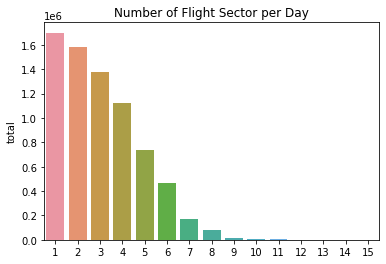

In [71]:
data = pd.DataFrame(df['nth_sector'].value_counts())
data.columns = ['total']


plt.title("Number of Flight Sector per Day")
sns.barplot(data.index,
            data.total);

Sorting our dataframe by `flightdate`, `tail_number` and `nth_sector`

In [72]:
df = df.sort_values(by = ['flightdate','tail_number','nth_sector'])
df.reset_index(drop=True, inplace=True)
df.head()



year  month  dayofmonth  dayofweek flightdate  nth_sector  \
0  2019      1           1          2 2019-01-01           1   
1  2019      1           1          2 2019-01-01           2   
2  2019      1           1          2 2019-01-01           1   
3  2019      1           1          2 2019-01-01           2   
4  2019      1           1          2 2019-01-01           3   

  reporting_airline tail_number origin originstate dest deststate crsdeptime  \
0                G4       215NV    PGD          FL  RFD        IL       0810   
1                G4       215NV    RFD          IL  PGD        FL       1041   
2                G4       216NV    PIE          FL  TOL        OH       0823   
3                G4       216NV    TOL          OH  PIE        FL       1131   
4                G4       216NV    PIE          FL  GRR        MI       1443   

   crsdephour  deptime  depdelay  taxiout  taxiin crsarrtime  crsarrhour  \
0           8      805         0       54       4       0956           9   
1          10     1127        46        9      14       1422          14   
2           8      815         0       10       5       1046          10   
3          11     1119         0        5       7       1353          13   
4          14     1438         0        8       7       1720          17   

   arrtime  arrdelay  crselapsedtime  actualelapsedtime  airtime  distance  \
0     1029        33             166                204      146      1127   
1     1523        61             161                176      153      1127   
2     1030         0             143                135      120       945   
3     1334         0             142                135      123       945   
4     1655         0             157                137      122      1044   

   distancegroup  carrierdelay  weatherdelay  nasdelay  securitydelay  \
0              5             0             0        33              0   
1              5            13             0        15              0   
2              4             0             0         0              0   
3              4             0             0         0              0   
4              5             0             0         0              0   

   lateaircraftdelay  arr_delayed  dep_delayed  delay  log_distance  \
0                  0            1            0      1      5.111988   
1                 33            1            1      1      5.081404   
2                  0            0            0      0      4.962845   
3                  0            0            0      0      4.955827   
4                  0            0            0      0      5.056246   

   log_crselapsedtime  
0            5.111988  
1            5.081404  
2            4.962845  
3            4.955827  
4            5.056246

The number of sectors flown by the aircrafts in our dataset ranges from 1 to 15 sectors per day, but most aircraft flew 6 or less sectors per day. <br>
Choosing a random 10-sector flight to check that the `nth_sector` was added correctly:

In [76]:
df[(df['flightdate'] == '2019-01-01')
   &(df['tail_number'] == 'N489HA')][
    ['flightdate','nth_sector','crsdeptime','origin','crsarrtime','dest']]

flightdate  nth_sector crsdeptime origin crsarrtime dest
6131 2019-01-01           1       0503    HNL       0543  OGG
6132 2019-01-01           2       0611    OGG       0649  HNL
6133 2019-01-01           3       0725    HNL       0806  LIH
6134 2019-01-01           4       0834    LIH       0910  HNL
6135 2019-01-01           5       0950    HNL       1031  LIH
6136 2019-01-01           6       1059    LIH       1145  OGG
6137 2019-01-01           7       1215    OGG       1255  HNL
6138 2019-01-01           8       1405    HNL       1450  OGG
6139 2019-01-01           9       1518    OGG       1555  KOA
6140 2019-01-01          10       1625    KOA       1713  HNL

In [77]:
nth_sector_df = pd.DataFrame(round(df.groupby('reporting_airline')['nth_sector'].mean(),2))
nth_sector_df.columns = ['mean_nth_sector']
nth_sector_df

mean_nth_sector
reporting_airline                 
9E                            3.25
AA                            2.58
AS                            2.50
B6                            2.76
DL                            2.79
EV                            2.87
F9                            2.90
G4                            2.92
HA                            4.87
MQ                            3.44
NK                            2.92
OH                            3.74
OO                            3.37
UA                            2.37
WN                            3.44
YV                            3.16
YX                            3.19

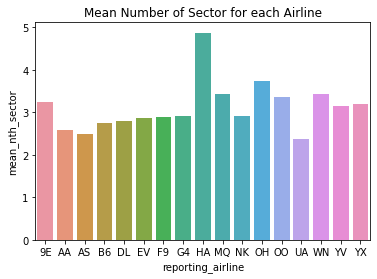

In [78]:
plt.title("Mean Number of Sector for each Airline")
sns.barplot(nth_sector_df.index,
            nth_sector_df.mean_nth_sector);

Comparing the mean number of sectors each aircraft covers per day, can see that `HA` (Hawaiian Airlines) has the highest mean, this is probably because `HA` has more short-haul flights and/or a tighter daily schedule. As compared to `UA` (United Airlines) which has the lowest mean, this is probably because `UA` has more long-haul flights and/or less a less busy schedule. 

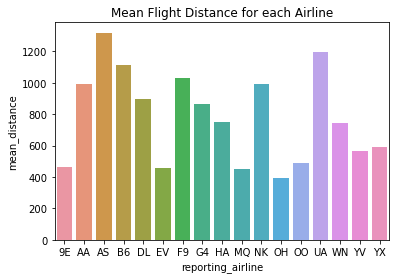

In [79]:
data = pd.DataFrame(round(df.groupby('reporting_airline')['distance'].mean(),2))
data.columns = ['mean_distance']


plt.title("Mean Flight Distance for each Airline")
sns.barplot(data.index,
            data.mean_distance);

## Previous Sector Delay

In [80]:
df.head(20)

year  month  dayofmonth  dayofweek flightdate  nth_sector  \
0   2019      1           1          2 2019-01-01           1   
1   2019      1           1          2 2019-01-01           2   
2   2019      1           1          2 2019-01-01           1   
3   2019      1           1          2 2019-01-01           2   
4   2019      1           1          2 2019-01-01           3   
5   2019      1           1          2 2019-01-01           4   
6   2019      1           1          2 2019-01-01           1   
7   2019      1           1          2 2019-01-01           2   
8   2019      1           1          2 2019-01-01           3   
9   2019      1           1          2 2019-01-01           4   
10  2019      1           1          2 2019-01-01           1   
11  2019      1           1          2 2019-01-01           2   
12  2019      1           1          2 2019-01-01           3   
13  2019      1           1          2 2019-01-01           4   
14  2019      1           1          2 2019-01-01           1   
15  2019      1           1          2 2019-01-01           2   
16  2019      1           1          2 2019-01-01           3   
17  2019      1           1          2 2019-01-01           4   
18  2019      1           1          2 2019-01-01           1   
19  2019      1           1          2 2019-01-01           2   

   reporting_airline tail_number origin originstate dest deststate crsdeptime  \
0                 G4       215NV    PGD          FL  RFD        IL       0810   
1                 G4       215NV    RFD          IL  PGD        FL       1041   
2                 G4       216NV    PIE          FL  TOL        OH       0823   
3                 G4       216NV    TOL          OH  PIE        FL       1131   
4                 G4       216NV    PIE          FL  GRR        MI       1443   
5                 G4       216NV    GRR          MI  PIE        FL       1805   
6                 G4       217NV    AVL          NC  PIE        FL       1230   
7                 G4       217NV    PIE          FL  AVL        NC       1453   
8                 G4       217NV    AVL          NC  SFB        FL       1716   
9                 G4       217NV    SFB          FL  AVL        NC       1949   
10                G4       218NV    SFB          FL  XNA        AR       0820   
11                G4       218NV    XNA          AR  SFB        FL       1033   
12                G4       218NV    SFB          FL  FWA        IN       1547   
13                G4       218NV    FWA          IN  SFB        FL       1849   
14                G4       219NV    SFB          FL  ABE        PA       0805   
15                G4       219NV    ABE          PA  SFB        FL       1114   
16                G4       219NV    SFB          FL  DSM        IA       1433   
17                G4       219NV    DSM          IA  SFB        FL       1711   
18                G4       220NV    SFB          FL  PBG        NY       0815   
19                G4       220NV    PBG          NY  SFB        FL       1153   

    crsdephour  deptime  depdelay  taxiout  taxiin crsarrtime  crsarrhour  \
0            8      805         0       54       4       0956           9   
1           10     1127        46        9      14       1422          14   
2            8      815         0       10       5       1046          10   
3           11     1119         0        5       7       1353          13   
4           14     1438         0        8       7       1720          17   
5           18     1805         0       22       4       2040          20   
6           12     1220         0        7       6       1408          14   
7           14     1434         0        8      36       1626          16   
8           17     1707         0       11       5       1849          18   
9           19     1933         0       10       7       2117          21   
10           8      904        44       14      14       0948           9   
11          

In [81]:
orignal_col = ['origin','crsarrhour','airtime','distance','arrdelay','arr_delayed']
previous_col = [str('previous_' + col) for col in orignal_col]

In [82]:
for i in range(len(orignal_col)):
    df.insert(
    df.columns.get_loc(orignal_col[i]) + 1, previous_col[i],
    df.loc[df['nth_sector'].shift(-1)>1, orignal_col[i]])
    
    df[previous_col[i]] = df[previous_col[i]].shift()

In [83]:
df.head(30)

year  month  dayofmonth  dayofweek flightdate  nth_sector  \
0   2019      1           1          2 2019-01-01           1   
1   2019      1           1          2 2019-01-01           2   
2   2019      1           1          2 2019-01-01           1   
3   2019      1           1          2 2019-01-01           2   
4   2019      1           1          2 2019-01-01           3   
5   2019      1           1          2 2019-01-01           4   
6   2019      1           1          2 2019-01-01           1   
7   2019      1           1          2 2019-01-01           2   
8   2019      1           1          2 2019-01-01           3   
9   2019      1           1          2 2019-01-01           4   
10  2019      1           1          2 2019-01-01           1   
11  2019      1           1          2 2019-01-01           2   
12  2019      1           1          2 2019-01-01           3   
13  2019      1           1          2 2019-01-01           4   
14  2019      1           1          2 2019-01-01           1   
15  2019      1           1          2 2019-01-01           2   
16  2019      1           1          2 2019-01-01           3   
17  2019      1           1          2 2019-01-01           4   
18  2019      1           1          2 2019-01-01           1   
19  2019      1           1          2 2019-01-01           2   
20  2019      1           1          2 2019-01-01           3   
21  2019      1           1          2 2019-01-01           4   
22  2019      1           1          2 2019-01-01           1   
23  2019      1           1          2 2019-01-01           2   
24  2019      1           1          2 2019-01-01           1   
25  2019      1           1          2 2019-01-01           2   
26  2019      1           1          2 2019-01-01           3   
27  2019      1           1          2 2019-01-01           4   
28  2019      1           1          2 2019-01-01           1   
29  2019      1           1          2 2019-01-01           2   

   reporting_airline tail_number origin previous_origin originstate dest  \
0                 G4       215NV    PGD             NaN          FL  RFD   
1                 G4       215NV    RFD             PGD          IL  PGD   
2                 G4       216NV    PIE             NaN          FL  TOL   
3                 G4       216NV    TOL             PIE          OH  PIE   
4                 G4       216NV    PIE             TOL          FL  GRR   
5                 G4       216NV    GRR             PIE          MI  PIE   
6                 G4       217NV    AVL             NaN          NC  PIE   
7                 G4       217NV    PIE             AVL          FL  AVL   
8                 G4       217NV    AVL             PIE          NC  SFB   
9                 G4       217NV    SFB             AVL          FL  AVL   
10                G4       218NV    SFB             NaN          FL  XNA   
11                G4       218NV    XNA             SFB          AR  SFB   
12                G4       218NV    SFB             XNA          FL  FWA   
13                G4       218NV    FWA             SFB          IN  SFB   
14                G4       219NV    SFB             NaN          FL  ABE   
15                G4       219NV    ABE             SFB          PA  SFB   
16                G4       219NV    SFB             ABE          FL  DSM   
17                G4       219NV    DSM             SFB          IA  SFB   
18                G4       220NV    SFB             NaN          FL  PBG   
19                G4       220NV    PBG             SFB          NY  SFB   
20                G4       220NV    SFB             PBG          FL  GRR   
21                G4       220NV    GRR             SFB          MI  SFB   
22                G4       221NV    SFB             NaN          FL  BGR   
23                G4       221NV    BGR             SFB          ME  SFB   
24                G4       222NV    TYS             NaN          TN  PGD   
25          

In [84]:
df = df.fillna(0)
df.isnull().sum()

year                    0
month                   0
dayofmonth              0
dayofweek               0
flightdate              0
nth_sector              0
reporting_airline       0
tail_number             0
origin                  0
previous_origin         0
originstate             0
dest                    0
deststate               0
crsdeptime              0
crsdephour              0
deptime                 0
depdelay                0
taxiout                 0
taxiin                  0
crsarrtime              0
crsarrhour              0
previous_crsarrhour     0
arrtime                 0
arrdelay                0
previous_arrdelay       0
crselapsedtime          0
actualelapsedtime       0
airtime                 0
previous_airtime        0
distance                0
previous_distance       0
distancegroup           0
carrierdelay            0
weatherdelay            0
nasdelay                0
securitydelay           0
lateaircraftdelay       0
arr_delayed             0
previous_arr

## Cyclical Features Encoding
Some data is inherently cyclical, e.g. Clock representation of 24-hour cyclic data

Hours of the day, days of the week, months in a year are examples of features that are cyclical. We want to convert these features into a representation that can preserve the cyclical properties (i.e.: hour 23 and hour 0 being close to each other and not far). [Feature Engineering - Handling Cyclical Features](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

We will do some trigonometric data conversion since cyclical data can naturally fit into a circular representation.

In [85]:
# Trigonometric data conversion for day_of_week :
df['sin_day_of_week'] = np.sin((df.dayofweek-1) * (2*np.pi)/7)
df['cos_day_of_week'] = np.cos((df.dayofweek-1) * (2*np.pi)/7)

# Trigonometric data conversion for month :
df['sin_month'] = np.sin((df.month-1) * (2*np.pi)/12)
df['cos_month'] = np.cos((df.month-1) * (2*np.pi)/12)

# Trigonometric data conversion for day_of_month :
df['sin_day_of_month'] = np.sin((df.dayofmonth-1) * (2*np.pi)/31)
df['cos_day_of_month'] = np.cos((df.dayofmonth-1) * (2*np.pi)/31)

# Trigonometric data conversion for crs_dep_time :
df['sin_crs_dep_time'] = np.sin(df.crsdephour * (2*np.pi)/24)
df['cos_crs_dep_time'] = np.cos(df.crsdephour * (2*np.pi)/24)

# Trigonometric data conversion for crs_arr_time :
df['sin_crs_arr_time'] = np.sin(df.crsarrhour * (2*np.pi)/24)
df['cos_crs_arr_time'] = np.cos(df.crsarrhour * (2*np.pi)/24)

df.iloc[:,-10:].head(3)

sin_day_of_week  cos_day_of_week  sin_month  cos_month  sin_day_of_month  \
0         0.781831          0.62349        0.0        1.0               0.0   
1         0.781831          0.62349        0.0        1.0               0.0   
2         0.781831          0.62349        0.0        1.0               0.0   

   cos_day_of_month  sin_crs_dep_time  cos_crs_dep_time  sin_crs_arr_time  \
0               1.0          0.866025         -0.500000          0.707107   
1               1.0          0.500000         -0.866025         -0.500000   
2               1.0          0.866025         -0.500000          0.500000   

   cos_crs_arr_time  
0         -0.707107  
1         -0.866025  
2         -0.866025

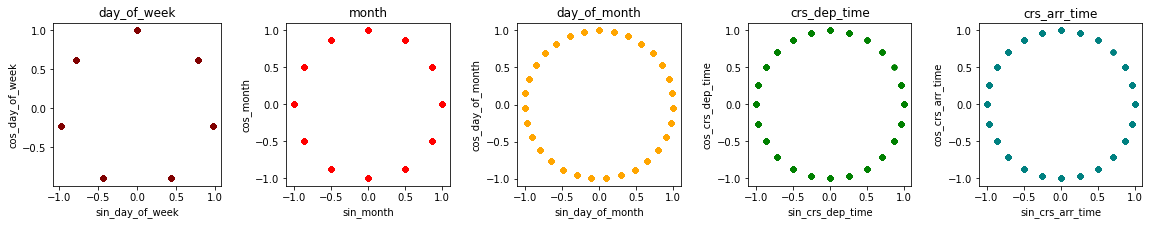

In [86]:
# randomly extracting 1% of the data to plot
data = df.sample(frac = 0.01)

# getting the new columns from our trigonometric data conversion
cyclic_columns = df.iloc[:,-10:].columns

# plotting a scatterplot to visualise our output from the trigonometric data conversion 
fig, ax = plt.subplots(1,5, figsize=(20,3))

# colours for visualisation
colors = ['maroon','red', 'orange', 'green', 'teal']

for i in range(5):
    data.plot.scatter(cyclic_columns[i*2],
                      cyclic_columns[i*2+1],
                      color=colors[i],
                     ax=ax[i]).set_aspect('equal')
    
    ax[i].title.set_text(cyclic_columns[i*2][4:])

## Dropping Features


In [87]:
print(f'Before dropping features: {df.shape}')

keep_features = df.drop([
    #'index',
    # Dropping the original time features and keep the trigonometric converted features
    'year', 'month', 'dayofmonth', 'dayofweek', 'flightdate',
    'crsarrtime', 'crsarrhour','crsdeptime','crsdephour',
    'arrtime','deptime','actualelapsedtime','airtime',
    
    # Dropping the tail number, an aircraft unique identifier
    'tail_number',
    
    # Dropping the origin and destination states and keep origin and destination airport
    'originstate','deststate',
    
    # Dropping the reasons for delay, as these features are only available AFTER the flight
    'carrierdelay', 'weatherdelay', 'nasdelay',
    'securitydelay', 'lateaircraftdelay', 
    
    # Dropping arrival and depature delayed indicator as we already have a delay indicator
    'arr_delayed', 'dep_delayed',
    
    # Dropping distance as we already have distance group
    'distance'

], axis=1, inplace=False).columns

print()
print('Features to Keep:')
print(keep_features)
print()

df0 = df[keep_features]
pickle.dump(df0, open('flight_data_2019_df0.pkl', 'wb'))
print(f'After dropping features: {df0.shape}')

Before dropping features: (7268123, 53)

Features to Keep:
Index(['nth_sector', 'reporting_airline', 'origin', 'previous_origin', 'dest',
       'depdelay', 'taxiout', 'taxiin', 'previous_crsarrhour', 'arrdelay',
       'previous_arrdelay', 'crselapsedtime', 'previous_airtime',
       'previous_distance', 'distancegroup', 'previous_arr_delayed', 'delay',
       'log_distance', 'log_crselapsedtime', 'sin_day_of_week',
       'cos_day_of_week', 'sin_month', 'cos_month', 'sin_day_of_month',
       'cos_day_of_month', 'sin_crs_dep_time', 'cos_crs_dep_time',
       'sin_crs_arr_time', 'cos_crs_arr_time'],
      dtype='object')

After dropping features: (7268123, 29)


We will randomly extract 10% of the data as running the full dataset (~7.2 million rows) will require high computation power and time. We will save the truncated person (10%) of `df` as a new DataFrame `df2`, and export it as a pickle file so that will not need to redo the data cleaning.

In [88]:
df1 = df0.sample(frac=0.1)
print(df1.shape)

df1.reset_index(drop=True, inplace=True)

# Saving df1 as a pickle file
pickle.dump(df1, open('flight_data_2019_df1.pkl', 'wb'))

df1.head(3)

(726812, 29)


nth_sector reporting_airline origin previous_origin dest  depdelay  \
0           6                WN    ELP             SAN  LAX        91   
1           3                UA    OGG             SFO  SFO         0   
2           1                MQ    ATW               0  ORD         0   

   taxiout  taxiin  previous_crsarrhour  arrdelay  previous_arrdelay  \
0        7       7                 17.0        80               75.0   
1       11       7                 13.0         0                0.0   
2        9       7                  0.0         0                0.0   

   crselapsedtime  previous_airtime  previous_distance  distancegroup  \
0             125              82.0              636.0              3   
1             300             291.0             2338.0             10   
2              69               0.0                0.0              1   

   previous_arr_delayed  delay  log_distance  log_crselapsedtime  \
0                   1.0      1      4.828314            4.828314   
1                   0.0      0      5.703782            5.703782   
2                   0.0      0      4.234107            4.234107   

   sin_day_of_week  cos_day_of_week  sin_month     cos_month  \
0        -0.433884        -0.900969  -0.866025  5.000000e-01   
1         0.433884        -0.900969   1.000000  6.123234e-17   
2         0.974928        -0.222521   0.500000 -8.660254e-01   

   sin_day_of_month  cos_day_of_month  sin_crs_dep_time  cos_crs_dep_time  \
0          0.299363         -0.954139         -0.965926         -0.258819   
1         -0.299363         -0.954139         -0.500000         -0.866025   
2         -0.937752          0.347305          0.965926          0.258819   

   sin_crs_arr_time  cos_crs_arr_time  
0              -1.0     -1.836970e-16  
1              -0.5      8.660254e-01  
2               1.0      6.123234e-17

In [89]:
print(df1['depdelay'].min())
df1['depdelay'] = [delay if delay >15 else 0 for delay in df1['depdelay']]
print(df1['depdelay'].min())
print()

0
0



## Statistical Test
Reference: [Customer Churn Prediction \<by Shilpa\>](https://github.com/shilpaleo/customer_churn_prediction/blob/main/notebooks/customer_churn.ipynb)

In [64]:
df1 = pickle.load(open('./flight_data_2019_df1.pkl', 'rb'))
print(df1.shape)


(726812, 29)


In [65]:
df1.head()

nth_sector reporting_airline origin previous_origin dest  depdelay  \
0           6                WN    ELP             SAN  LAX        91   
1           3                UA    OGG             SFO  SFO         0   
2           1                MQ    ATW               0  ORD         0   
3           7                WN    OKC             DAL  DEN         0   
4           4                DL    DTW             RSW  DEN         0   

   taxiout  taxiin  previous_crsarrhour  arrdelay  previous_arrdelay  \
0        7       7                 17.0        80               75.0   
1       11       7                 13.0         0                0.0   
2        9       7                  0.0         0                0.0   
3       11       5                 19.0         0                0.0   
4       20       8                 15.0         0                0.0   

   crselapsedtime  previous_airtime  previous_distance  distancegroup  \
0             125              82.0              636.0              3   
1             300             291.0             2338.0             10   
2              69               0.0                0.0              1   
3             100              40.0              181.0              2   
4             190             143.0             1084.0              5   

   previous_arr_delayed  delay  log_distance  log_crselapsedtime  \
0                   1.0      1      4.828314            4.828314   
1                   0.0      0      5.703782            5.703782   
2                   0.0      0      4.234107            4.234107   
3                   0.0      0      4.605170            4.605170   
4                   0.0      0      5.247024            5.247024   

   sin_day_of_week  cos_day_of_week     sin_month     cos_month  \
0        -0.433884        -0.900969 -8.660254e-01  5.000000e-01   
1         0.433884        -0.900969  1.000000e+00  6.123234e-17   
2         0.974928        -0.222521  5.000000e-01 -8.660254e-01   
3         0.000000         1.000000  8.660254e-01  5.000000e-01   
4        -0.433884        -0.900969  1.224647e-16 -1.000000e+00   

   sin_day_of_month  cos_day_of_month  sin_crs_dep_time  cos_crs_dep_time  \
0          0.299363         -0.954139         -0.965926         -0.258819   
1         -0.299363         -0.954139         -0.500000         -0.866025   
2         -0.937752          0.347305          0.965926          0.258819   
3          0.897805         -0.440394         -0.866025          0.500000   
4         -0.937752          0.347305         -0.866025         -0.500000   

   sin_crs_arr_time  cos_crs_arr_time  
0         -1.000000     -1.836970e-16  
1         -0.500000      8.660254e-01  
2          1.000000      6.123234e-17  
3         -0.866025      5.000000e-01  
4         -0.965926     -2.588190e-01

### Categorical Features

In [66]:
# subsetting categorical features to run statistical : chi-square test
df1_cat = df1.select_dtypes(include=['object'])

# joining response variable, target variable into categorical features dataframe
df1_cat = df1_cat.join(df1[['delay']])

print(df1_cat.shape)
df1_cat.head(3)

(726812, 5)


reporting_airline origin previous_origin dest  delay
0                WN    ELP             SAN  LAX      1
1                UA    OGG             SFO  SFO      0
2                MQ    ATW               0  ORD      0

In [67]:
# label encoding for categorical features to convert values to numeric
label_encoder = LabelEncoder()

f1_cat_transformed_dict = {}

for col in df1_cat.columns:
    df1_cat[col] = label_encoder.fit_transform(df1_cat[col].astype(str))
    df1_cat_transformed = label_encoder.fit_transform(df1_cat[col])
    f1_cat_transformed_dict[col] = df1_cat_transformed
    
df1_cat_transformed = pd.DataFrame(f1_cat_transformed_dict)
print(df1_cat_transformed.shape)
df1_cat_transformed.head(3)

(726812, 5)


reporting_airline  origin  previous_origin  dest  delay
0                 14     109              297   188      1
1                 13     241              309   309      0
2                  9      22                0   247      0

In [68]:
# running chi-square test
X = df1_cat_transformed.drop('delay',axis=1)
y = df1_cat_transformed['delay']

chi_scores = chi2(X,y)
chi_scores

(array([4.05932550e-02, 1.67343332e+03, 2.80317110e+05, 4.69739333e+03]),
 array([0.84032508, 0.        , 0.        , 0.        ]))

In [69]:
# visualizing top correlated features + p_values from chi-square test
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(inplace=True)

fig = px.bar(p_values,
             labels={'value': 'P-value'},
             width=400,
             height=400,
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.add_hline(y=0.05, line_dash="dash", line_color="salmon")
fig.update_xaxes(title_text='Feature')
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle=90)

In [70]:
# top correlated features + p_values converted to dataframe for top features list extraction
df1_cat_pv = pd.DataFrame(p_values, columns=['p_value'])

df1_cat_top_features = df1_cat_pv[df1_cat_pv['p_value']<0.05].index.to_list()

print(f'Number of Categorical Feature Columns: {len(df1_cat_pv.index)}')
print()
print(f'Categorical Features: {df1_cat_top_features}')

df1_cat_pv

Number of Categorical Feature Columns: 4

Categorical Features: ['origin', 'previous_origin', 'dest']


p_value
origin             0.000000
previous_origin    0.000000
dest               0.000000
reporting_airline  0.840325

### Continuous Features

In [71]:
# subsetting continuous features to run statistical : anova/KS test
df1_cont = df1.select_dtypes(include=['int64','float64'])

print(df1_cont.shape)
df1_cont.head(3)

(726812, 25)


nth_sector  depdelay  taxiout  taxiin  previous_crsarrhour  arrdelay  \
0           6        91        7       7                 17.0        80   
1           3         0       11       7                 13.0         0   
2           1         0        9       7                  0.0         0   

   previous_arrdelay  crselapsedtime  previous_airtime  previous_distance  \
0               75.0             125              82.0              636.0   
1                0.0             300             291.0             2338.0   
2                0.0              69               0.0                0.0   

   distancegroup  previous_arr_delayed  delay  log_distance  \
0              3                   1.0      1      4.828314   
1             10                   0.0      0      5.703782   
2              1                   0.0      0      4.234107   

   log_crselapsedtime  sin_day_of_week  cos_day_of_week  sin_month  \
0            4.828314        -0.433884        -0.900969  -0.866025   
1            5.703782         0.433884        -0.900969   1.000000   
2            4.234107         0.974928        -0.222521   0.500000   

      cos_month  sin_day_of_month  cos_day_of_month  sin_crs_dep_time  \
0  5.000000e-01          0.299363         -0.954139         -0.965926   
1  6.123234e-17         -0.299363         -0.954139         -0.500000   
2 -8.660254e-01         -0.937752          0.347305          0.965926   

   cos_crs_dep_time  sin_crs_arr_time  cos_crs_arr_time  
0         -0.258819              -1.0     -1.836970e-16  
1         -0.866025              -0.5      8.660254e-01  
2          0.258819               1.0      6.123234e-17

In [72]:
# extracting all continuous feature column
df1_cont_cols = [col for col in df1_cont.columns if col not in ['delay']]

print(f'Number of Continuous Feature Columns: {len(df1_cont_cols)}')
print()
print(f'Continuous Features:')
df1_cont_cols

Number of Continuous Feature Columns: 24

Continuous Features:


['nth_sector',
 'depdelay',
 'taxiout',
 'taxiin',
 'previous_crsarrhour',
 'arrdelay',
 'previous_arrdelay',
 'crselapsedtime',
 'previous_airtime',
 'previous_distance',
 'distancegroup',
 'previous_arr_delayed',
 'log_distance',
 'log_crselapsedtime',
 'sin_day_of_week',
 'cos_day_of_week',
 'sin_month',
 'cos_month',
 'sin_day_of_month',
 'cos_day_of_month',
 'sin_crs_dep_time',
 'cos_crs_dep_time',
 'sin_crs_arr_time',
 'cos_crs_arr_time']

In [73]:
# defining function to run statistical significance test on continuous variables

def cont_stat_sig_test(df,col):
    # defining function for normality + statistical significance check
    # Step 1: normality test
    stat, p_value = stats.normaltest(df1[col].values)
    
    # Step 2: filter series    
    nodelay = df1[df1['delay']==0][col].values
    delay = df1[df1['delay']==1][col].values
    
    # Step 3: determining appropriate statistical significance test based on normality
    if p_value>0.01:
        distribution = 'Normal Distribution'
        test = 'Anova test'
        stat, p_value = stats.f_oneway(nodelay, delay)
    
    else:
        distribution = 'Non-Normal Distribution'
        test = 'KS test'
        stat, p_value = stats.ks_2samp(nodelay, delay)
    
    # Step 4: conclude on statistical significance
    if p_value>0.05:
        sig = 'Not Statistically Significant'
    else:
        sig = 'Statistically Significant'

    print(f'{col} has a {distribution}: \nResult of {test} : {sig}')
    print()
    return p_value

In [74]:
# running normality and statistical significance tests on continuous features
results_dict = {col:cont_stat_sig_test(df1_cont,col) for col in df1_cont_cols}

cont_stat_results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['p_value']).sort_values(by='p_value')

fig=px.bar(cont_stat_results_df, labels={'value': 'p_value'}, width=600, height=500, color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)

nth_sector has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

depdelay has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

taxiout has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

taxiin has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

previous_crsarrhour has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

arrdelay has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

previous_arrdelay has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

crselapsedtime has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

previous_airtime has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

previous_distance has a Non-Normal Distribution: 
Result of KS test : Statistically Significant

distancegroup has a Non-Normal Distribution: 
Result of KS test : Statisticall

In [75]:
# continuous features with statistical significance correlation (p-value<0.05)
cont_stat_results_df

p_value
nth_sector             0.000000e+00
cos_crs_dep_time       0.000000e+00
sin_crs_dep_time       0.000000e+00
sin_month              0.000000e+00
sin_crs_arr_time       0.000000e+00
previous_distance      0.000000e+00
previous_airtime       0.000000e+00
previous_arr_delayed   0.000000e+00
previous_arrdelay      0.000000e+00
arrdelay               0.000000e+00
previous_crsarrhour    0.000000e+00
taxiout                0.000000e+00
depdelay               0.000000e+00
cos_crs_arr_time       0.000000e+00
log_distance          2.317495e-273
log_crselapsedtime    2.317495e-273
crselapsedtime        2.317495e-273
cos_month             1.071376e-239
distancegroup         1.265671e-174
taxiin                4.186628e-142
cos_day_of_month      2.899486e-119
cos_day_of_week        6.268006e-61
sin_day_of_month       2.542295e-31
sin_day_of_week        4.819186e-29

In [76]:
# rearranging cont_train dataset's feature columns in the order of statistical significance
cont_train = df1_cont[['delay']+cont_stat_results_df.index.tolist()]
cont_feature_cols = df1_cont.columns.tolist()
cont_feature_cols.remove('delay')
print(cont_train.shape)
cont_train.head()

(726812, 25)


delay  nth_sector  cos_crs_dep_time  sin_crs_dep_time     sin_month  \
0      1           6         -0.258819         -0.965926 -8.660254e-01   
1      0           3         -0.866025         -0.500000  1.000000e+00   
2      0           1          0.258819          0.965926  5.000000e-01   
3      0           7          0.500000         -0.866025  8.660254e-01   
4      0           4         -0.500000         -0.866025  1.224647e-16   

   sin_crs_arr_time  previous_distance  previous_airtime  \
0         -1.000000              636.0              82.0   
1         -0.500000             2338.0             291.0   
2          1.000000                0.0               0.0   
3         -0.866025              181.0              40.0   
4         -0.965926             1084.0             143.0   

   previous_arr_delayed  previous_arrdelay  arrdelay  previous_crsarrhour  \
0                   1.0               75.0        80                 17.0   
1                   0.0                0.0         0                 13.0   
2                   0.0                0.0         0                  0.0   
3                   0.0                0.0         0                 19.0   
4                   0.0                0.0         0                 15.0   

   taxiout  depdelay  cos_crs_arr_time  log_distance  log_crselapsedtime  \
0        7        91     -1.836970e-16      4.828314            4.828314   
1       11         0      8.660254e-01      5.703782            5.703782   
2        9         0      6.123234e-17      4.234107            4.234107   
3       11         0      5.000000e-01      4.605170            4.605170   
4       20         0     -2.588190e-01      5.247024            5.247024   

   crselapsedtime     cos_month  distancegroup  taxiin  cos_day_of_month  \
0             125  5.000000e-01              3       7         -0.954139   
1             300  6.123234e-17             10       7         -0.954139   
2              69 -8.660254e-01              1       7          0.347305   
3             100  5.000000e-01              2       5         -0.440394   
4             190 -1.000000e+00              5       8          0.347305   

   cos_day_of_week  sin_day_of_month  sin_day_of_week  
0        -0.900969          0.299363        -0.433884  
1        -0.900969         -0.299363         0.433884  
2        -0.222521         -0.937752         0.974928  
3         1.000000          0.897805         0.000000  
4        -0.900969         -0.937752        -0.433884

In [77]:
# heatmap to visualize correlated features: multicollinearity
pearson_corr_features = df1_cont.corr()
corr_data = np.tril(pearson_corr_features,k=-1)
corr_data = abs(corr_data)>0.90

fig = px.imshow(corr_data, x=pearson_corr_features.columns, y=pearson_corr_features.index,
                color_continuous_scale=px.colors.qualitative.Plotly, width=800, height=600,
                title="Continuous Features with Strong Correlation Coefficient (>0.9)")
fig.update(layout_coloraxis_showscale=False)
fig.show()

`depdelay` and `arrdelay` are strongly correlated. We will drop `depdelay`.

We note that the distance and elapsed time features are strongly correlated. It is natural that time and distance are directly proportional and this is inevitable, but we will still keep both features given that both are important features for this prediction.

In [78]:
df1.drop(['arrdelay'], axis=1, inplace=True)
df1.head(1)

nth_sector reporting_airline origin previous_origin dest  depdelay  \
0           6                WN    ELP             SAN  LAX        91   

   taxiout  taxiin  previous_crsarrhour  previous_arrdelay  crselapsedtime  \
0        7       7                 17.0               75.0             125   

   previous_airtime  previous_distance  distancegroup  previous_arr_delayed  \
0              82.0              636.0              3                   1.0   

   delay  log_distance  log_crselapsedtime  sin_day_of_week  cos_day_of_week  \
0      1      4.828314            4.828314        -0.433884        -0.900969   

   sin_month  cos_month  sin_day_of_month  cos_day_of_month  sin_crs_dep_time  \
0  -0.866025        0.5          0.299363         -0.954139         -0.965926   

   cos_crs_dep_time  sin_crs_arr_time  cos_crs_arr_time  
0         -0.258819              -1.0     -1.836970e-16

## Multicollinearity

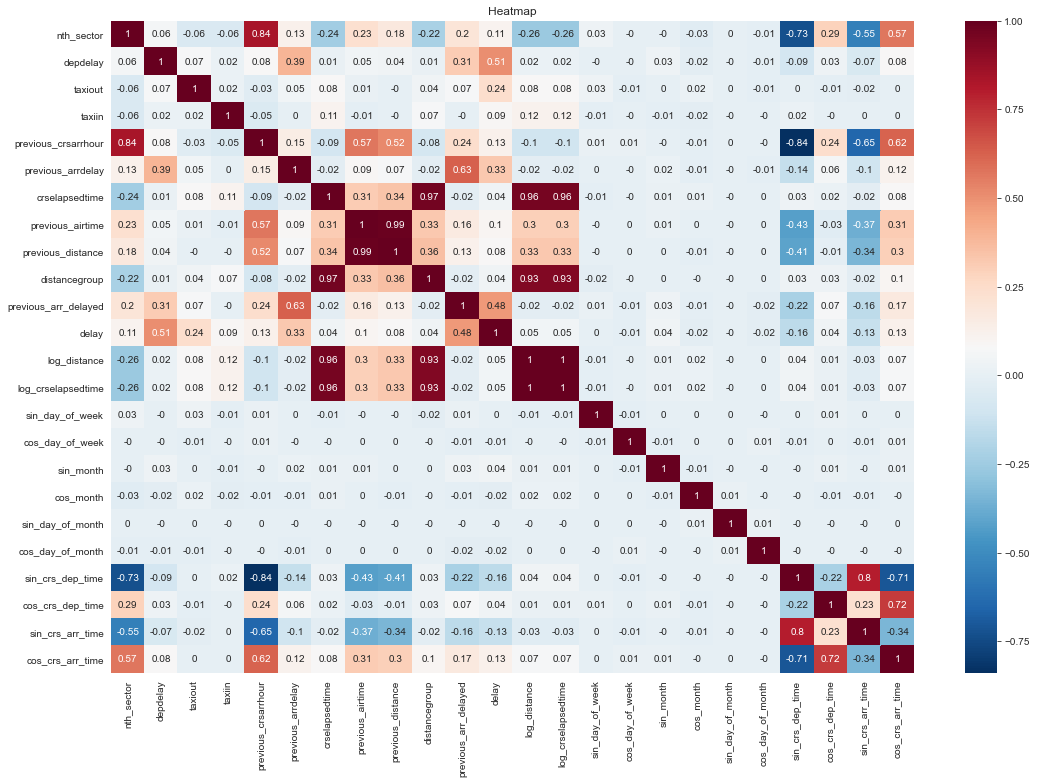

In [79]:
plt.figure(figsize=(18,12))
plt.title("Heatmap")
sns.heatmap(round(df1.corr(),2), annot=True, cmap='RdBu_r');

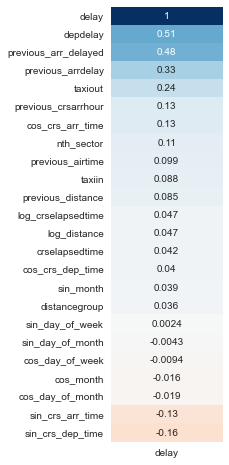

In [80]:
# correlations of features vs target variable (delay)
plt.figure(figsize=(2, 8))
sns.heatmap(df1.corr()[['delay']].sort_values('delay', ascending=False), 
            cmap='RdBu', 
            vmin=-1, 
            vmax=1,
            annot=True, 
           cbar=False);

## Polynomial Feature Engineering

Based on the correlation coefficients, our features have relatively weak correlation to our target variable. We will try to do some polynomial feature engineering and hope that we are able to improve the correlation to the target.
Looking at the interactions of features with correlations (features vs target variable) > 0.15

In [81]:
X = df1[[col for col in df1.columns if 'delay' not in col]]._get_numeric_data()
y = df1['delay']

print(f'Feature Variables - X :{X.shape}')
print(f'Target Variable - y :{y.shape}')
print()

# polynomial feature
polynomial = PolynomialFeatures(include_bias=False, degree=2)
poly_X = polynomial.fit_transform(X)

print(f'Polynomial Features - poly_X :{poly_X.shape}')

Feature Variables - X :(726812, 20)
Target Variable - y :(726812,)

Polynomial Features - poly_X :(726812, 230)


In [82]:
# adding feature names of polynomial features
poly_X = pd.DataFrame(poly_X,columns=polynomial.get_feature_names(X.columns))

# finding the correlations of the poly features with respect to target variable y
poly_X_corr_y = poly_X.corrwith(y)

# putting polynomial features and its coefficients in a dataframe
poly_X_corr_y = pd.DataFrame(poly_X.corrwith(y), columns=['corr'])
poly_X_corr_y = poly_X_corr_y.sort_values(by='corr', ascending=False)

# sieving out features with absolute correlation coefficient > 0.15
poly_X_corr_y2 = poly_X_corr_y[abs(poly_X_corr_y['corr']) > 0.15]
poly_X_corr_y2

corr
taxiout                              0.236055
taxiout log_crselapsedtime           0.236027
taxiout log_distance                 0.236027
taxiout previous_crsarrhour          0.234766
nth_sector taxiout                   0.226953
taxiout^2                            0.225065
taxiout taxiin                       0.197674
taxiout previous_airtime             0.184906
taxiout crselapsedtime               0.180104
taxiout previous_distance            0.165686
taxiout distancegroup                0.161709
taxiout sin_crs_dep_time            -0.156324
sin_crs_dep_time                    -0.158686
log_distance sin_crs_dep_time       -0.158784
log_crselapsedtime sin_crs_dep_time -0.158784
taxiout sin_crs_arr_time            -0.172229

Surprisingly, all the polynomial features that are positively correlated to y involves the `taxiout` feature, and most of our the features that are negatively correlated to y involves the `sin_crs_dep_time` feature. 

We will not add all the polynomial features into our model, we will choose some polynomial features to avoid multicollinearity issues.

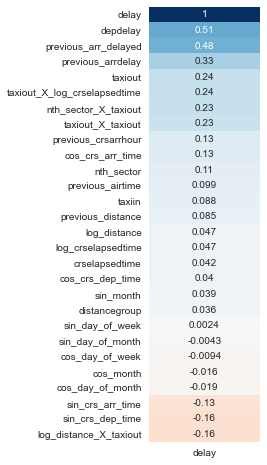

In [83]:
# choosing features to create interaction features
df1['taxiout_X_log_crselapsedtime'] = df1['taxiout'] * df1['log_crselapsedtime']
df1['nth_sector_X_taxiout'] = df1['nth_sector'] * df1['taxiout']
df1['taxiout_X_taxiout'] = df1['taxiout'] * df1['taxiout']
df1['log_distance_X_taxiout'] = df1['log_distance'] * df1['sin_crs_dep_time']

features_corr = pd.DataFrame((df1.corr()['delay']).sort_values(ascending=False))

plt.figure(figsize=(2, 8))
sns.heatmap(features_corr, 
            cmap='RdBu', 
            vmin=-1, 
            vmax=1,
            annot=True, 
           cbar=False);

In [84]:
# we will keep these polynomial features since they have more than 1% correlation to delay
keep_features = ['nth_sector', 'reporting_airline', 'origin', 'dest',
       'taxiout', 'taxiin', 'crselapsedtime', 'distancegroup',
       'delay', 'log_distance', 'log_crselapsedtime', 'sin_day_of_week',
       'cos_day_of_week', 'sin_month', 'cos_month', 'sin_day_of_month',
       'cos_day_of_month', 'sin_crs_dep_time', 'cos_crs_dep_time',
       'sin_crs_arr_time', 'cos_crs_arr_time']


[keep_features.append(feature) for feature in [
    'taxiout_X_log_crselapsedtime',
    'nth_sector_X_taxiout',
    'taxiout_X_taxiout',
    'log_distance_X_taxiout']]

keep_features

['nth_sector',
 'reporting_airline',
 'origin',
 'dest',
 'taxiout',
 'taxiin',
 'crselapsedtime',
 'distancegroup',
 'delay',
 'log_distance',
 'log_crselapsedtime',
 'sin_day_of_week',
 'cos_day_of_week',
 'sin_month',
 'cos_month',
 'sin_day_of_month',
 'cos_day_of_month',
 'sin_crs_dep_time',
 'cos_crs_dep_time',
 'sin_crs_arr_time',
 'cos_crs_arr_time',
 'taxiout_X_log_crselapsedtime',
 'nth_sector_X_taxiout',
 'taxiout_X_taxiout',
 'log_distance_X_taxiout']

## One-Hot Encoding

In [85]:
print(f'Categorical Features:')
[print(col) for col in df1.select_dtypes(include=['object']).columns]
print()
df2=pd.get_dummies(df1,  columns=df1.select_dtypes(include=['object']).columns, drop_first=False)
pickle.dump(df2, open('flight_data_2019_df2.pkl', 'wb'))

print(df2.shape)
df2.head(1)

Categorical Features:
reporting_airline
origin
previous_origin
dest

(726812, 1124)


nth_sector  depdelay  taxiout  taxiin  previous_crsarrhour  \
0           6        91        7       7                 17.0   

   previous_arrdelay  crselapsedtime  previous_airtime  previous_distance  \
0               75.0             125              82.0              636.0   

   distancegroup  previous_arr_delayed  delay  log_distance  \
0              3                   1.0      1      4.828314   

   log_crselapsedtime  sin_day_of_week  cos_day_of_week  sin_month  cos_month  \
0            4.828314        -0.433884        -0.900969  -0.866025        0.5   

   sin_day_of_month  cos_day_of_month  sin_crs_dep_time  cos_crs_dep_time  \
0          0.299363         -0.954139         -0.965926         -0.258819   

   sin_crs_arr_time  cos_crs_arr_time  taxiout_X_log_crselapsedtime  \
0              -1.0     -1.836970e-16                     33.798196   

   nth_sector_X_taxiout  taxiout_X_taxiout  log_distance_X_taxiout  \
0                    42                 49               -4.663793   

   reporting_airline_9E  reporting_airline_AA  reporting_airline_AS  \
0                     0                     0                     0   

   reporting_airline_B6  reporting_airline_DL  reporting_airline_EV  \
0                     0                     0                     0   

   reporting_airline_F9  reporting_airline_G4  reporting_airline_HA  \
0                     0                     0                     0   

   reporting_airline_MQ  reporting_airline_NK  reporting_airline_OH  \
0                     0                     0                     0   

   reporting_airline_OO  reporting_airline_UA  reporting_airline_WN  \
0                     0                     0                     1   

   reporting_airline_YV  reporting_airline_YX  origin_ABE  origin_ABI  \
0                     0                     0           0           0   

   origin_ABQ  origin_ABR  origin_ABY  origin_ACK  origin_ACT  origin_ACV  \
0           0           0           0           0           0           0   

   origin_ACY  origin_ADK  origin_ADQ  origin_AEX  origin_AGS  origin_AKN  \
0           0           0           0           0           0           0   

   origin_ALB  origin_ALO  origin_AMA  origin_ANC  origin_APN  origin_ART  \
0           0           0           0           0           0           0   

   origin_ASE  origin_ATL  origin_ATW  origin_ATY  origin_AUS  origin_AVL  \
0           0           0           0           0           0           0   

   origin_AVP  origin_AZA  origin_AZO  origin_BDL  origin_BET  origin_BFF  \
0           0           0           0           0           0           0   

   origin_BFL  origin_BFM  origin_BGM  origin_BGR  origin_BHM  origin_BIL  \
0           0           0           0           0           0           0   

   origin_BIS  origin_BJI  origin_BKG  origin_BLI  origin_BLV  origin_BMI  \
0           0           0           0           0           0           0   

   origin_BNA  origin_BOI  origin_BOS  origin_BPT  origin_BQK  origin_BQN  \
0           0           0           0           0           0           0   

   origin_BRD  origin_BRO  origin_BRW  origin_BTM  origin_BTR  origin_BTV  \
0           0           0           0           0           0           0   

   origin_BUF  origin_BUR  origin_BWI  origin_BZN  origin_CAE  origin_CAK  \
0           0           0           0           0           0           0   

   origin_CDC  origin_CDV  origin_CGI  origin_CHA  origin_CHO  origin_CHS  \
0           0           0           0           0           0           0   

   origin_CID  origin_CIU  origin_CKB  origin_CLE  origin_CLL  origin_CLT  \
0           0           0           0           0           0           0   

   origin_CMH  origin_CMI  origin_CMX  origin_CNY  origin_COD  origin_COS  \
0           0           0           0           0           0           0   

   origin_COU  origin_CPR  origin_CRP  origin_CRW  origin_CSG  origin_CVG  \
0           0           0         

In [86]:
dum_X = df2[[col for col in df2.columns if 'delay' not in col]]._get_numeric_data()
dum_y = df2['delay']

print(f'Dummified Feature Variables - X :{dum_X.shape}')
print(f'Dummified Target Variable - y :{dum_y.shape}')

Dummified Feature Variables - X :(726812, 1120)
Dummified Target Variable - y :(726812,)


In [87]:
# adding feature names of polynomial features
dum_X = pd.DataFrame(dum_X,columns=dum_X.columns)

# finding the correlations of the poly features with respect to target variable y
dum_X_corr_y = dum_X.corrwith(dum_y)

# putting polynomial features and its coefficients in a dataframe
dum_X_corr_y = pd.DataFrame(dum_X.corrwith(dum_y), columns=['corr'])
dum_X_corr_y = dum_X_corr_y.sort_values(by='corr', ascending=False)

# sieving out features with absolute correlation coefficient > 0.03
dum_X_corr_y = dum_X_corr_y[abs(dum_X_corr_y['corr']) > 0.01]
dum_X_corr_y

corr
taxiout                       0.236055
taxiout_X_log_crselapsedtime  0.236027
nth_sector_X_taxiout          0.226953
taxiout_X_taxiout             0.225065
previous_crsarrhour           0.134873
cos_crs_arr_time              0.130277
nth_sector                    0.105883
previous_airtime              0.098806
taxiin                        0.088166
previous_distance             0.084509
log_crselapsedtime            0.046770
log_distance                  0.046770
crselapsedtime                0.041680
cos_crs_dep_time              0.040285
sin_month                     0.038592
dest_EWR                      0.038330
distancegroup                 0.035585
previous_origin_EWR           0.034864
reporting_airline_B6          0.034680
origin_ORD                    0.033370
previous_origin_LGA           0.031013
previous_origin_ORD           0.030864
dest_LGA                      0.028713
dest_SFO                      0.028384
origin_EWR                    0.028125
reporting_airline_F9          0.024791
origin_LGA                    0.023053
reporting_airline_AA          0.021827
previous_origin_BOS           0.020997
previous_origin_SFO           0.020954
origin_DFW                    0.020798
origin_DEN                    0.020240
previous_origin_FLL           0.019656
dest_BOS                      0.017856
dest_ORD                      0.017049
previous_origin_DFW           0.016550
previous_origin_MCO           0.016461
reporting_airline_UA          0.015561
reporting_airline_EV          0.014522
origin_SFO                    0.013546
previous_origin_MDW           0.013493
previous_origin_JFK           0.013282
origin_MDW                    0.012922
previous_origin_DEN           0.012667
dest_FLL                      0.011745
origin_BOS                    0.010935
previous_origin_DCA           0.010367
previous_origin_IAH           0.010262
origin_FLL                    0.010099
origin_SMF                   -0.010294
origin_ITO                   -0.010594
origin_LIH                   -0.010625
reporting_airline_9E         -0.010830
dest_ITO                     -0.010868
dest_KOA                     -0.010962
previous_origin_KOA          -0.010982
origin_MSP                   -0.011716
origin_SJC                   -0.011800
dest_CLT                     -0.011985
dest_OGG                     -0.012075
origin_OGG                   -0.012230
origin_ANC                   -0.012260
origin_PDX                   -0.012625
previous_origin_OGG          -0.012706
dest_HNL                     -0.013710
origin_KOA                   -0.013886
dest_MSP                     -0.014150
dest_SLC                     -0.014619
dest_DTW                     -0.015157
cos_month                    -0.016477
origin_SLC                   -0.016930
origin_ATL                   -0.017012
origin_HNL                   -0.018105
cos_day_of_month             -0.018610
previous_origin_HNL          -0.020982
reporting_airline_HA         -0.025484
dest_ATL                     -0.030633
reporting_airline_DL         -0.046847
previous_origin_0            -0.093955
sin_crs_arr_time             -0.134758
sin_crs_dep_time             -0.158686
log_distance_X_taxiout       -0.158784

In [88]:
df2 = pickle.load(open('./flight_data_2019_df2.pkl', 'rb'))

In [89]:
dum_X = df2[[col for col in df2.columns if 'delay' not in col]]._get_numeric_data()
dum_y = df2['delay']

print(f'Dummified Feature Variables - X :{dum_X.shape}')
print(f'Dummified Target Variable - y :{dum_y.shape}')

Dummified Feature Variables - X :(726812, 1120)
Dummified Target Variable - y :(726812,)


In [90]:
# adding feature names of polynomial features
dum_X = pd.DataFrame(dum_X,columns=dum_X.columns)

# finding the correlations of the poly features with respect to target variable y
dum_X_corr_y = dum_X.corrwith(dum_y)

# putting polynomial features and its coefficients in a dataframe
dum_X_corr_y = pd.DataFrame(dum_X.corrwith(dum_y), columns=['corr'])
dum_X_corr_y = dum_X_corr_y.sort_values(by='corr', ascending=False)

# sieving out features with absolute correlation coefficient > 0.03
dum_X_corr_y = dum_X_corr_y[abs(dum_X_corr_y['corr']) > 0.03]
dum_X_corr_y

corr
taxiout                       0.236055
taxiout_X_log_crselapsedtime  0.236027
nth_sector_X_taxiout          0.226953
taxiout_X_taxiout             0.225065
previous_crsarrhour           0.134873
cos_crs_arr_time              0.130277
nth_sector                    0.105883
previous_airtime              0.098806
taxiin                        0.088166
previous_distance             0.084509
log_crselapsedtime            0.046770
log_distance                  0.046770
crselapsedtime                0.041680
cos_crs_dep_time              0.040285
sin_month                     0.038592
dest_EWR                      0.038330
distancegroup                 0.035585
previous_origin_EWR           0.034864
reporting_airline_B6          0.034680
origin_ORD                    0.033370
previous_origin_LGA           0.031013
previous_origin_ORD           0.030864
dest_ATL                     -0.030633
reporting_airline_DL         -0.046847
previous_origin_0            -0.093955
sin_crs_arr_time             -0.134758
sin_crs_dep_time             -0.158686
log_distance_X_taxiout       -0.158784

In [91]:
keep_features2 = keep_features + list(dum_X_corr_y.index)
len(keep_features2)

53

In [92]:
for col in ['origin', 'dest', 'reporting_airline']:
    keep_features2.remove(col)
    
len(keep_features2)

50

In [93]:
df3 = df2[keep_features2]
pickle.dump(df3, open('flight_data_2019_df3.pkl', 'wb'))
df3.shape

(726812, 50)

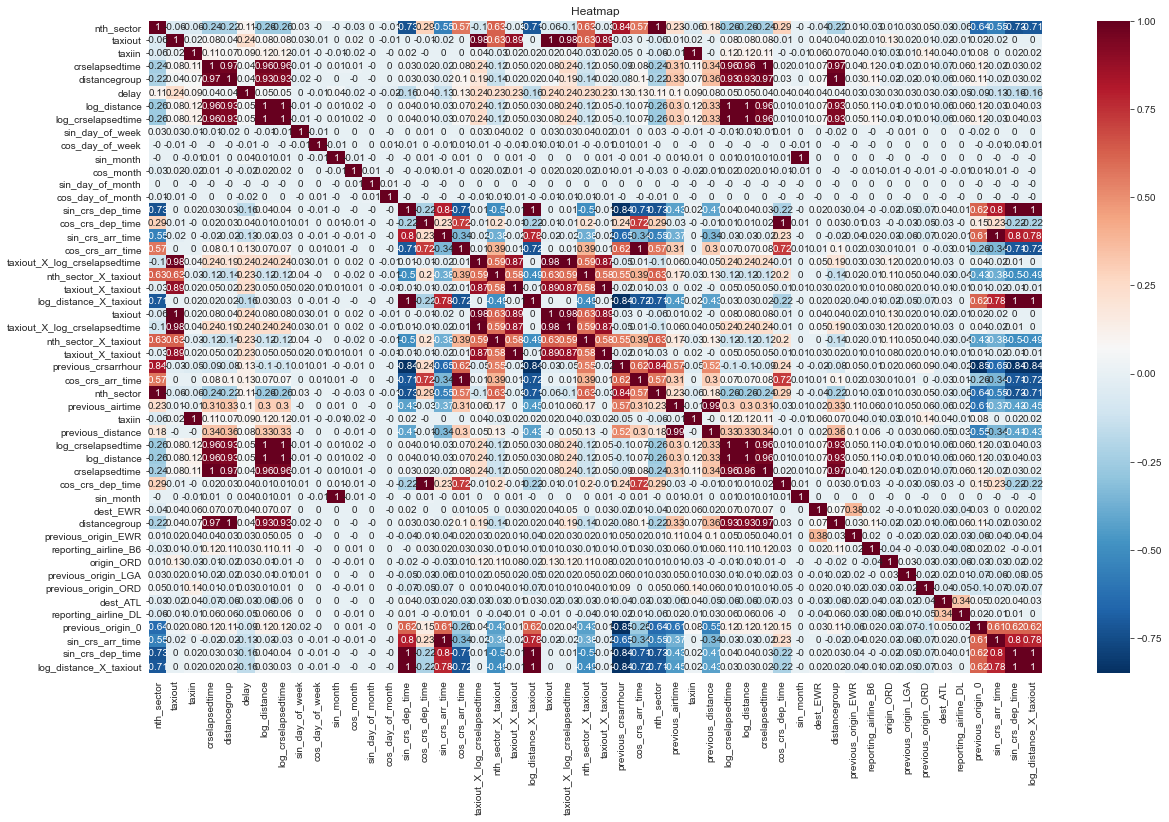

In [94]:
plt.figure(figsize=(20,12))
plt.title("Heatmap")
sns.heatmap(round(df3.corr(),2), annot=True, cmap='RdBu_r');

# Model Training & Tuning 

## Baseline

In [95]:
from sklearn.model_selection import train_test_split, GridSearchCV
df3 = pickle.load(open('./flight_data_2019_df3.pkl', 'rb'))


In [96]:
X = df3.drop('delay', axis=1)
y= df3['delay']

print(f'X: {X.shape}')
print(f'y: {y.shape}')

y.value_counts(normalize=True)

X: (726812, 49)
y: (726812,)


0    0.781556
1    0.218444
Name: delay, dtype: float64

Our target class are unbalanced, where ~78.2% of the flights did not experience a delay (`delay` $=0$) and ~21.8% of the flights that experienced a delay (`delay` $=1$).

## Train Test Split

In [97]:
# Train test split (70% train, 30% test)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state=42,
                                                    stratify=y)
print(f'X Train: {X_train.shape}')
print(f'X Test: {X_test.shape}')
print(f'y Train: {y_train.shape}')
print(f'y Test: {y_test.shape}')

X Train: (508768, 49)
X Test: (218044, 49)
y Train: (508768,)
y Test: (218044,)


In [98]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Logistic Regression

### Balanced Weighted Class

In [113]:
pipe = Pipeline([('logreg', LogisticRegression(class_weight='balanced'))])

pipe_params = {
    'logreg__solver': ['newton-cg','liblinear'],
    'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logreg__C': [0.1],
    'logreg__random_state': [42]
}

gs_logreg = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=5)

# Fit GridSearch to training data.
gs_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'logreg__C': [0.1],
                         'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'logreg__random_state': [42],
                         'logreg__solver': ['newton-cg', 'liblinear']})

In [114]:
y_pred_logreg = gs_logreg.predict(X_test)

print('Best Score:', gs_logreg.best_score_)
print('Best Params:', gs_logreg.best_params_)
print("-------------------------------------------")
print('Score Model on Training Set:', gs_logreg.score(X_train, y_train))
print('Score Model on Testing Set:', gs_logreg.score(X_test, y_test))

Best Score: 0.6467348612388136
Best Params: {'logreg__C': 0.1, 'logreg__penalty': 'none', 'logreg__random_state': 42, 'logreg__solver': 'newton-cg'}
-------------------------------------------
Score Model on Training Set: 0.646707340084282
Score Model on Testing Set: 0.6464154023958467


### Manual Weighted Class 

In [48]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}


In [49]:
param_grid

{'class_weight': [{0: 0.0, 1: 1.0},
  {0: 0.2475, 1: 0.7525},
  {0: 0.495, 1: 0.505},
  {0: 0.7424999999999999, 1: 0.25750000000000006},
  {0: 0.99, 1: 0.010000000000000009}]}

In [50]:
#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Text(0.5, 1.0, 'Scoring for different class weights')

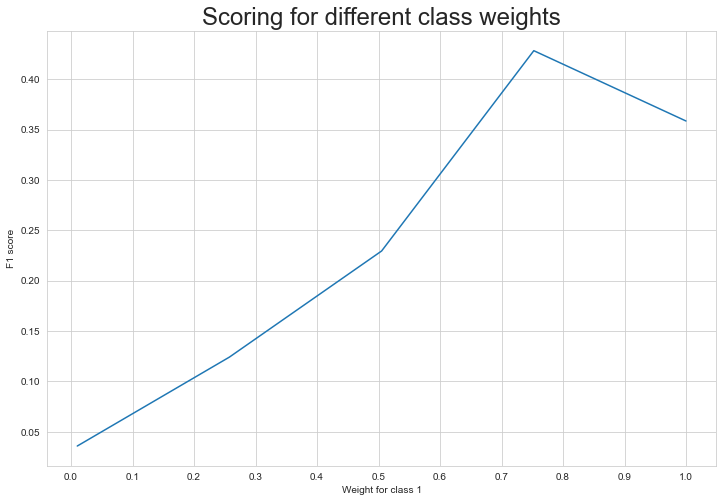

In [51]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

Through the graph we can see that the highest value for the minority class is peaking at about 0.75 class weight.
Now that we have our best class weights using stratified cross-validation and grid search, we will see the performance on the test data.

In [55]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.7424999999999999, 1: 0.25750000000000006})
lr.fit(X_train, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test)


In [62]:
y_pred_lr = lr.predict(X_test)

print('Score Model on Training Set:', lr.score(X_train, y_train))
print('Score Model on Testing Set:', lr.score(X_test, y_test))

Score Model on Training Set: 0.7946234826089691
Score Model on Testing Set: 0.794770780209499


## Random Forest

In [207]:
pipe = Pipeline([('rf', RandomForestClassifier())])

pipe_params = {
    'rf__n_estimators': [400,500],
    'rf__max_depth': [None],   
    'rf__max_features': [None, 16],
    'rf__min_samples_split':[2], 
    'rf__min_samples_leaf':[2]}

In [208]:
gs_rf = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=5)

# Fit GridSearch to training data.
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None],
                         'rf__max_features': [None, 16],
                         'rf__min_samples_leaf': [2],
                         'rf__min_samples_split': [2],
                         'rf__n_estimators': [400, 500]})

In [31]:
y_pred_rf = gs_rf.predict(X_test)

print('Best Score:', gs_rf.best_score_)
print('Best Params:', gs_rf.best_params_)
print("-------------------------------------------")
print('Score Model on Training Set:', gs_rf.score(X_train, y_train))
print('Score Model on Testing Set:', gs_rf.score(X_test, y_test))

Best Score: 0.8005593903028736
Best Params:{'rf__max_depth': None, 'rf__max_features': 16, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
-------------------------------------------
Score Model on Training Set: 0.9859444776401032
Score Model on Testing Set: 0.8011043642567555


## AdaBoost

In [205]:
pipe = Pipeline([('ab', AdaBoostClassifier())])

pipe_params = {
    'ab__n_estimators': [300, 400],
    'ab__learning_rate': [1]
    }

gs_ab = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=5)

# Fit GridSearch to training data.
gs_ab.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('ab', AdaBoostClassifier())]),
             param_grid={'ab__learning_rate': [1],
                         'ab__n_estimators': [300, 400]})

In [309]:
y_pred_ab = gs_ab.predict(X_test)

print('Best Score:', gs_ab.best_score_)
print('Best Params:', gs_ab.best_params_)
print("-------------------------------------------")
print('Score Model on Training Set:', gs_ab.score(X_train, y_train))
print('Score Model on Testing Set:', gs_ab.score(X_test, y_test))

Best Score: 0.7997279688553457
Best Params: {'ab__learning_rate': 1, 'ab__n_estimators': 300}
-------------------------------------------
Score Model on Training Set: 0.7998203503364991
Score Model on Testing Set: 0.799003870778375


In [92]:
# Saving models in pickle
pickle.dump(gs_logreg, open('LogisticRegression_Balanced.sav', 'wb'))
pickle.dump(lr, open('LogisticRegression_ManualWeights.sav', 'wb'))
pickle.dump(gs_rf, open('RandomForest.sav', 'wb'))
pickle.dump(gs_ab, open('AdaBoost.sav', 'wb'))

# Model Evaluation

In [ ]:
gs_logreg = pickle.load(open('LogisticRegression_Balanced.sav', 'rb'))
lr = pickle.load(open('LogisticRegression_ManualWeights.sav', 'rb'))
gs_rf = pickle.load(open('RandomForest.sav', 'rb'))
gs_ab = pickle.load(open('AdaBoost.sav', 'rb'))

## Metric

In [94]:
def metric_df(y_pred_model, model):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_model).ravel()

    accuracy = metrics.accuracy_score(y_test, y_pred_model) # (tp+tn)/(tp+tn+fp+fn)
    sensitivity = metrics.recall_score(y_test, y_pred_model) # tp/(tp+fn) 
    specificity = tn/(tn+fp) 
    precision = metrics.precision_score(y_test, y_pred_model) # tp/(tp+fp) 
    f1 = f1_score(y_test,y_pred_model) # 2 * (precision * sensitivity) / (precision + sensitivity)


    metric_values = [accuracy, sensitivity, specificity ,precision, f1]
    metric_list = ["Accuracy", "Sensitivity/Recall", "Specificity","Precision","F1 score"]

    metric_values = [str(round(metric*100,2))+"%" for metric in metric_values]

    # collating scores from the different models into a dataframe
    metric_df = pd.DataFrame({
        'Metric': metric_list,
        'Score': metric_values}, index=None)
    print(f"{model} Model Evaluation:")
    return metric_df.style.hide_index()

In [96]:
metric_df(y_pred_logreg, "Logistic Regression (Balanced)")

Logistic Regression (Balanced) Model Evaluation:


In [97]:
metric_df(y_pred_lr, "Logistic Regression (Manually Weighted)")

Logistic Regression (Manually Weighted) Model Evaluation:


In [337]:
metric_df(y_pred_rf, "Random Forest")

Random Forest Model Evaluation:


In [338]:
metric_df(y_pred_ab, "AdaBoost")

AdaBoost Model Evaluation:


Given that our class is imbalanced, it is not hard to decide on the best model based on the F1 Score:

| Model                                   | Train  | Test   | Recall | F1 Score |
|-----------------------------------------|--------|--------|--------|----------|
| Logistic Regression (Balanced Weighted) | 0.6467 | 0.6464 | 0.6211 | 0.4342   |
| Logistic Regression (Manually Weighted) | 0.7946 | 0.7947 | 0.0670 | 0.1254   |
| Random Forest                           | 0.9859 | 0.8011 | 0.1748 | 0.2195   |
| AdaBoost                                | 0.7998 | 0.7990 | 0.1381 | 0.2195   |

## Confusion Matrix 

We will create a function to visualize our confusion matrix [Source](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

In [69]:
def plot_cmatrix(matrix, title):
    
    group_names = ['True Negatives','False Positives','False Negatives','True Positives']
    group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    group_percentages = ['({0:.2%})'.format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2) # reshape labels
    
    sns.heatmap((matrix), 
                annot=labels,
                annot_kws={"size": 15}, 
                cmap='Greys', 
                fmt="", 
                xticklabels=True, 
                yticklabels=True,
                cbar=False); 

    plt.title (f'Confusion Matrix of {title}', size=18)
    plt.ylabel('True Class', size=15)
    plt.xlabel('Predicted Class', size=15)
    plt.yticks(size = 15)
    plt.xticks(size = 15);

F1 Score for the Testing Set: 0.43420444287884463


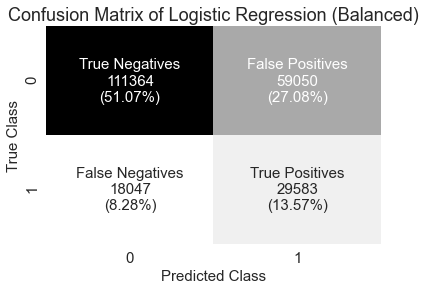

In [83]:
#Ploting the confusion matrix
plot_cmatrix(confusion_matrix(y_test, y_pred_logreg), 'Logistic Regression (Balanced)')

#Calculating and printing the f1 score 
f1_logreg = f1_score(y_test, y_pred_logreg)
print('F1 Score for the Testing Set:', f1_logreg)

## Best Model

In [115]:
print('Score Model on Training Set:', gs_logreg.score(X_train, y_train))
print('Score Model on Testing Set:', gs_logreg.score(X_test, y_test))

Score Model on Training Set: 0.646707340084282
Score Model on Testing Set: 0.6464154023958467


In [116]:
y_pred = gs_logreg.predict(X_test)
y_pred.shape

(218044,)

In [117]:
gs_logreg.best_params_

{'logreg__C': 0.1,
 'logreg__penalty': 'none',
 'logreg__random_state': 42,
 'logreg__solver': 'newton-cg'}

In [123]:
gs_best = gs_logreg

# Finding our Average Precision Score for our Train Set
train_probs = gs_best.predict_proba(X_train)[:, 1]
train_apc = average_precision_score(y_train, train_probs)
print(f'Train Set Average Precision Score:{train_apc}')

# Finding our Average Precision Score for our Test Set
test_probs = gs_best.predict_proba(X_test)[:, 1]
test_apc = average_precision_score(y_test, test_probs)
print(f'Test Set Average Precision Score:{test_apc}')


Train Set Average Precision Score:0.4497752954098251
Test Set Average Precision Score:0.4491258229496907


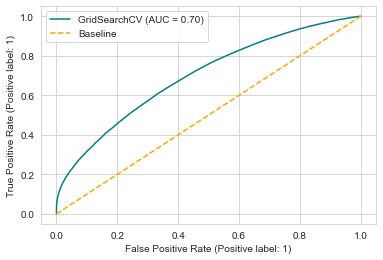

In [132]:
plot_roc_curve(gs_logreg, X_test, y_test, color= 'teal')
plt.plot([0, 1], [0, 1],label='Baseline', linestyle='--',  color='orange')
plt.legend();

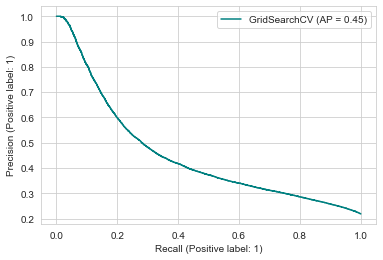

In [274]:
plot_precision_recall_curve(gs_logreg, X_test, y_test, color= 'teal')
plt.legend();

## Feature Importance

In [137]:
y_pred = gs_best.predict(X_test)
print(gs_best.score(X_test, y_test))

0.6464154023958467


In [152]:
gs_best = LogisticRegression(penalty='none', solver='newton-cg', C=0.1, random_state=42)
gs_best.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='none', random_state=42, solver='newton-cg')

In [189]:
# Creating a Dataframe for coefficients
logreg_coeff_df = pd.DataFrame(gs_best.coef_.tolist())
logreg_coeff_df.columns = list(df3.columns.drop('delay'))
logreg_coeff_df = logreg_coeff_df.T
logreg_coeff_df.columns = ['coeff']

# Sorting coefficients in descending order
logreg_coeff_df = logreg_coeff_df.sort_values(by='coeff')
logreg_coeff_df = logreg_coeff_df.drop_duplicates(keep='first')
logreg_coeff_df

# Truncated coefficients Dataframe with top 10 and botton 10 coefficients
logreg_coeff_df_10 = pd.concat([logreg_coeff_df.head(10), logreg_coeff_df.tail(10)])
logreg_coeff_df_10['coeff'] = round(logreg_coeff_df_10['coeff'],2)
logreg_coeff_df_10['coeff'] = [round(i,2) for i in logreg_coeff_df_10['coeff']]
logreg_coeff_df_10.T

previous_distance  taxiout_X_log_crselapsedtime  crselapsedtime  \
coeff              -1.01                          -0.3           -0.11   

       reporting_airline_DL  nth_sector_X_taxiout  cos_month  \
coeff                  -0.1                 -0.09      -0.07   

       sin_crs_arr_time  log_distance_X_taxiout  cos_day_of_month  \
coeff             -0.07                   -0.06             -0.05   

       sin_crs_dep_time  nth_sector  log_distance  reporting_airline_B6  \
coeff             -0.03        0.05          0.06                  0.07   

       distancegroup  taxiin  taxiout  previous_origin_0  previous_crsarrhour  \
coeff           0.07     0.1     0.22               0.26                 0.28   

       taxiout_X_taxiout  previous_airtime  
coeff               0.59              1.09

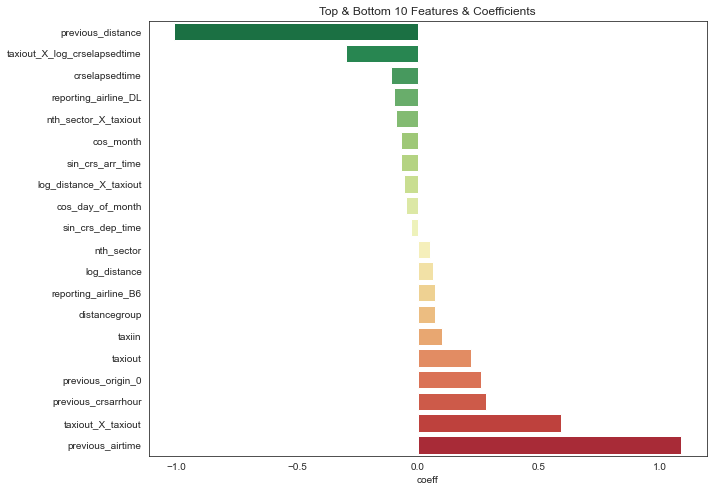

In [258]:
# Displaying truncated coefficients Dataframe in a barplot
plt.figure(figsize=(10,8))
sns.barplot(data=logreg_coeff_df_10, y=logreg_coeff_df_10.index, x='coeff', palette="RdYlGn_r")
plt.title('Top & Bottom 10 Features & Coefficients');

In [203]:
logreg_coeff_df_10['exp_coeff'] = [round((np.exp(abs(i))),2) for i in logreg_coeff_df_10['coeff']]
logreg_coeff_df_10_delay = logreg_coeff_df_10.tail(10)
print("Factors causing Delay")
logreg_coeff_df_10_delay.sort_values(by='exp_coeff',ascending=False).head(10)

Factors causing Delay


coeff  exp_coeff
previous_airtime       1.09       2.97
taxiout_X_taxiout      0.59       1.80
previous_crsarrhour    0.28       1.32
previous_origin_0      0.26       1.30
taxiout                0.22       1.25
taxiin                 0.10       1.11
reporting_airline_B6   0.07       1.07
distancegroup          0.07       1.07
log_distance           0.06       1.06
nth_sector             0.05       1.05

# Conclusion

## Recommendations

All airports and airlines face delays, and on many occasions, delays are inevitable. But if we are able to anticipate a delay, airlines will have more time to prepare contingency plans to cushion the impact of flight delays better. So what can airlines do to prepare for a delay?
    
**Maintaining Customer Satisfaction (Unavoidable Delays)**    

- Notifying passengers of possible delays in advance
- Deploy extra staff for that flight in view of longer flight hours 
- Preparing adequate food, water and amenity kits for customers
- Provide re-booking services or other flight alternatives in the event of a severe delay

**Better Flight Planning to Avoid Delays**

- Especially for low-cost carriers, most of their flights are short-haul. The core aspect of the business model depends heavily on quick aircraft turnaround. Hence, one delayed arrival can have a domino effect on the subsequent flights for that aircraft.
- With delay information easily available, airlines can plan better flight schedules or allocate more buffer time for aircraft turnaround. 
- Airlines may also assure passengers by offering well-planned flight connections or help holidaymakers make better decisions by providing suggestions, such as choosing a destinations with point-to-point flights to reduce the likelihood of a delay.

## Limitations

**Poor Metric Scores**

- Poor F1 Score due to poor Precision.

**US Context**

- International flights account for 25% of US flights, but flights in and out of US are not captured in our dataset. Foreign carriers do not report to the Bureau of Transportation Statistics on flights without a U.S. origin or destination.
- Our dataset is in the context of US. However, weather conditions and airports will be different outside of the US, so international flight data might not be a good fit for our model.

**Model Might not Applicable for Future Flights**

- Our model is built based on pre-COVID data, which would not be a good fit for post-COVID flight data, given all the changes in flight patterns.
- COVID-19 has changed consumer behaviors, especially when remote work and other flexible working arrangements are likely to remain post-pandemic. With this, business travel might take a long time to recover (if it even recovers), which means flight patterns might never be the same again.
- To build a robust model, we will need to train and test our model on data from different years.


## Possible Enhancements 


**Analysing Airports**
- Airport plays an important role in flight on-time performance and some of these airports are known to be prone to delays. For example, Newark Liberty International Airport is one of them, with 25% of their departing flights delayed. [Source](https://www.smartertravel.com/worst-airports-for-flight-delays/)
- Some of the reasons include inadequate air traffic control infrastructure or over congestion.
- As our dataset is limited to domestic flights only, we are not able to analyse airport delays or traffic.


**Methods to Handle Imbalanced Data**

There are many methods we can explore to handle imbalance classes. [Source](https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html)
- Synthetic Minority Oversampling Technique (SMOTE)
- Threshold Moving
- Random undersampling and oversampling
- Specifying a higher weight for the minority class 


**Regression Model to Predict Extent of Delay**
- To provide better insights by uncovering patterns and finding out the extent of delays, instead of a classification model, we can consider a regression model. To do so, we will need weather or other data sources.


**Complementing Weather Forecast with Real-Time Delay Prediction**

- 4% of the delays were due to extreme weather and 33% were due to NAS, and a large proportion of NAS delays were due to weather. According to BTS, 38.7% of the delays are due to poor weather conditions, which makes up a significant portion of delays. With accurate weather data, we would be able to improve our model and model sensitivity and F1 Score significantly.
- With accurate weather data, the flight delay prediction model may be complemented with weather forecast to predict real-time or future flight delays.


***


<a id='bottom'></a>
<a href='#top'>Back to Top</a>